- Quero fazer gráficos de sobreposição de mensagens por segundo dos dois ambientes para cada teste
    - Métricas do Kafka vindas do prometheus
- Quero fazer gráficos de sobreposição de vus dos dois ambientes para cada teste
    - Métricas do k6
- Quero fazer gráficos de sobreposição de latência dos dois ambientes para cada teste
    - Medição de latência do dataset delta lake
    - Métricas do k6
- Quero fazer gráficos de sobreposição de memória e CPU dos produtores para cada teste
    - Métricas do k6
- Quero fazer gráficos de comparativos do uso de CPU e memória de cada ambiente
    - Métricas do kubernetes vindas do prometheus


# Imports

In [1]:
import os
import fireducks.pandas as pd
import duckdb
import seaborn as sns
import matplotlib.pyplot as plt

# Functions

### Big Data Downsampling

In [3]:
def get_aggregated_data_duckdb(filepath, metric_name):
    """
    Efficiently loads and downsamples K6 CSV data using DuckDB.
    Filters by metric_name, groups by 1-second intervals, and calculates min/mean/max/p95/p99.
    Returns filtered and melted DataFrame ready for plotting.
    """
    query = f"""
    SELECT
        CAST(timestamp AS BIGINT) as timestamp,
        MIN(metric_value) as min_val,
        AVG(metric_value) as mean_val,
        MAX(metric_value) as max_val,
        QUANTILE_CONT(metric_value, 0.95) as p95_val,
        QUANTILE_CONT(metric_value, 0.99) as p99_val
    FROM read_csv('{filepath}', auto_detect=TRUE, header=TRUE)
    WHERE metric_name = '{metric_name}'
    GROUP BY timestamp
    ORDER BY timestamp
    """
    
    df = duckdb.query(query).to_df()
    
    # Melt matching the structure (now with p95 and p99)
    melted = df.melt(
        id_vars=['timestamp'], 
        value_vars=['min_val', 'mean_val', 'max_val', 'p95_val', 'p99_val'], 
        value_name='metric_value'
    )
    
    # Set metric_name col for consistency
    melted['metric_name'] = metric_name 
    
    return melted

def prepare_soak_data_for_chart(df_edge, df_cloud):
    """
    Prepares pre-aggregated soak data for charting.
    Aligns timestamps and adds environment labels.
    """
    # Align timestamps
    if not df_edge.empty:
        df_edge['relative_time'] = df_edge['timestamp'] - df_edge['timestamp'].min()
    if not df_cloud.empty:
        df_cloud['relative_time'] = df_cloud['timestamp'] - df_cloud['timestamp'].min()
        
    # Add Environment
    df_edge['Environment'] = 'Edge'
    df_cloud['Environment'] = 'Cloud'
    
    df_combined = pd.concat([df_edge, df_cloud])
    # relative_time is already numeric seconds (bigint)
    return df_combined


### Downsampling

In [4]:
def _downsample_for_plot(df: pd.DataFrame, x: str, y: str, rule: str) -> pd.DataFrame:
    """Downsamples the DataFrame for plotting by aggregating data over time intervals.

    Preserves outliers by keeping min, mean, and max for each interval.

    Args:
        df: The input DataFrame containing the data to be downsampled.
        x: The name of the column containing timestamp data.
        y: The name of the column containing the values to be aggregated.
        rule: The offset string or object representing target conversion (e.g., '1s', '1min').

    Returns:
        A new DataFrame with downsampled data containing min, mean, and max values
        for each interval, sorted by the timestamp column.
    """
    if df.empty or not rule:
        return df

    if not pd.api.types.is_datetime64_any_dtype(df[x]):
        df[x] = pd.to_datetime(df[x], unit="s", errors='coerce')
        # Drop rows where conversion failed (NaT) to prevent errors later
        df = df.dropna(subset=[x])

    # Resample and calculate min, mean, max
    # We aggregate y by the rule on x
    grouped = df.groupby(pd.Grouper(key=x, freq=rule))[y].agg(["min", "mean", "max"])

    # 3. Drop intervals with no data
    grouped = grouped.dropna()

    # 4. Flatten the result more efficiently
    # The 'grouped' dataframe has a MultiIndex on columns now.
    # We reset the index to bring the timestamp back as a column.
    grouped = grouped.reset_index()

    # We use 'melt' to unpivot the table. This is a vectorized operation 
    # that avoids the Python 'for' loop and keeps execution in the C++ backend longer.
    # Current cols: [timestamp, (y, 'min'), (y, 'mean'), (y, 'max')]
    
    # Flatten column names for melt to work easily
    grouped.columns = [x, 'min', 'mean', 'max']
    
    # Melt converts wide format (min, mean, max columns) into long format (one column)
    downsampled = grouped.melt(id_vars=[x], value_vars=['min', 'mean', 'max'], value_name=y)
    
    # The 'variable' column from melt will contain 'min', 'mean', 'max'. 
    # If you don't need that label column, you can drop it:
    downsampled = downsampled.drop(columns=['variable'])

    # Sort by timestamp
    downsampled = downsampled.sort_values(by=x)
    
    downsampled["metric_name"] = y
    return downsampled

def _filter_metric_and_downsample(df_edge, df_cloud, metric_name):
    df_edge = df_edge[df_edge['metric_name'] == metric_name]
    df_cloud = df_cloud[df_cloud['metric_name'] == metric_name]

    df_edge = _downsample_for_plot(df_edge, "timestamp", "metric_value", "1s")
    df_cloud = _downsample_for_plot(df_cloud, "timestamp", "metric_value", "1s")
    return df_edge, df_cloud

def _align_timestamps(df_edge, df_cloud):
    # Align timestamps (Create a relative time starting at 0)
    # This assumes 'timestamp' is numerical (unix epoch). 
    df_edge['relative_time'] = df_edge['timestamp'] - df_edge['timestamp'].min()
    df_cloud['relative_time'] = df_cloud['timestamp'] - df_cloud['timestamp'].min()
    return df_edge, df_cloud

def _add_environment_identifier(df_edge, df_cloud):
    # Add an identifier column for the legend
    df_edge['Environment'] = 'Edge'
    df_cloud['Environment'] = 'Cloud'
    return df_edge, df_cloud

def prepare_data_for_chart(df_edge, df_cloud, metric_name):
    df_edge, df_cloud = _filter_metric_and_downsample(df_edge, df_cloud, metric_name)
    df_edge, df_cloud = _align_timestamps(df_edge, df_cloud)
    df_edge, df_cloud = _add_environment_identifier(df_edge, df_cloud)
    df_combined = pd.concat([df_edge, df_cloud])
    df_combined["relative_time"] = df_combined["relative_time"].dt.seconds
    print(_get_aggregated_metrics(df_combined))
    return df_combined

def _get_aggregated_metrics(df_combined):
    return df_combined.groupby("Environment").agg(
        avg_metric=("metric_value", "mean"),
        max_metric=("metric_value", "max"),
        min_metric=("metric_value", "min"),
        median_metric=("metric_value", "median"),
        p95_metric=("metric_value", lambda x: x.quantile(0.95)),
        p99_metric=("metric_value", lambda x: x.quantile(0.99))
    )

def open_k6_files(edge_file, cloud_file):
    df_k6_edge = pd.read_csv(edge_file)
    df_k6_cloud = pd.read_csv(cloud_file)

    df_k6_edge = df_k6_edge.sort_values("timestamp")
    df_k6_cloud = df_k6_cloud.sort_values("timestamp")

    return df_k6_edge, df_k6_cloud

### Resources

In [5]:
TOTAL_MEM_KB = 15000000
    
def process_vmstat(df, env_label, total_mem):
  
    # Sort and Align Time
    start_time = df['timestamp'].min()
    df['relative_time'] = (df['timestamp'] - start_time).dt.total_seconds()
    
    # Calculate CPU Usage (%)
    # 'id' is idle time, so Used = 100 - Idle
    df['cpu_usage'] = 100 - df['id']
    
    # Calculate Memory Usage (%)
    # We calculate 'Active' memory (excluding Cache/Buffers)
    # Formula: (Total - Free - Buffers - Cache) / Total
    df['mem_usage'] = (total_mem - (df['free'] + df['buff'] + df['cache'])) / total_mem * 100
    
    df['Environment'] = env_label
    return df

def open_resources_files(edge_file, cloud_file):
    resources_k6_edge = pd.read_csv(edge_file, skiprows=1)
    resources_k6_cloud = pd.read_csv(cloud_file, skiprows=1)

    resources_k6_edge["timestamp"] = pd.to_datetime(resources_k6_edge["timestamp"])
    resources_k6_cloud["timestamp"] = pd.to_datetime(resources_k6_cloud["timestamp"])

    resources_k6_edge = resources_k6_edge.sort_values("timestamp")
    resources_k6_cloud = resources_k6_cloud.sort_values("timestamp")

    df_edge_res = process_vmstat(resources_k6_edge.copy(), 'Edge', TOTAL_MEM_KB)
    df_cloud_res = process_vmstat(resources_k6_cloud.copy(), 'Cloud', TOTAL_MEM_KB)

    # Combine for plotting
    df_resources = pd.concat([df_edge_res, df_cloud_res])
    return df_resources

def plot_resources(df_resources, save_path):
    # Plotting
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # Plot CPU
    sns.lineplot(data=df_resources, x='relative_time', y='cpu_usage', hue='Environment', ax=axes[0])
    axes[0].set_title('CPU Usage over Time')
    axes[0].set_ylabel('CPU Usage (%)')
    axes[0].grid(True)
    axes[0].set_ylim(0, 105) # Cap at 100% for readability

    # Plot Memory
    sns.lineplot(data=df_resources, x='relative_time', y='mem_usage', hue='Environment', ax=axes[1])
    axes[1].set_title('Memory Usage over Time (Application Only)')
    axes[1].set_ylabel('Memory Usage (%)')
    axes[1].set_xlabel('Time (seconds elapsed)')
    axes[1].grid(True)
    axes[1].set_ylim(0, 105) # Optional: Un-comment to fix y-axis to 0-100%

    plt.tight_layout()
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=400, bbox_inches="tight")
    plt.show()

def plot_vus(df_combined, save_path):
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=df_combined,
        x='relative_time',
        y='metric_value',
        hue='Environment',   # Colors differentiate Edge vs Cloud
        markers=False,
        dashes=True,
        err_style=None
    )

    plt.title('Active VUs vs Max VUs (Aligned)')
    plt.xlabel('Time Elapsed (s)')
    plt.ylabel('Virtual Users Count')
    plt.grid(True)
    plt.axhline(y=1200, color='red', linestyle='--', label='Target Max VUs (1200)')
    # plt.legend(loc='upper left')

    plt.savefig(save_path, dpi=400, bbox_inches="tight")
    plt.show()

### Time Series Analysis

In [6]:
def load_and_prepare(filename:str, start_time, end_time, columns:list[str]=["value", "kubernetes_pod_name", "job", "topic"])-> pd.DataFrame:
    """Loads a parquet file and ensures timestamp is index."""
    if not os.path.exists(filename):
        print(f"File {filename} not found.")
        raise Exception("File not Found")
    
    df = pd.read_parquet(filename)
    df = df[columns]

    df.index = df.index.to_series() - pd.Timedelta(hours=3)

    df = df[
            (df.index > start_time) &
            (df.index < end_time)
        ]

    #Usually index is the timestamp from Prometheus
    return df.sort_index()

def calculate_rate(df: pd.DataFrame, value_col='value', columns:list[str]=["kubernetes_pod_name", "topic"]) -> pd.Series:
    """Calculates the rate per second for counter metrics."""
    # Group by labels (topic, instance, etc.) to calculate rates correctly
    group_cols = columns
    
    def get_rate(group):
        # Rate = (val_t2 - val_t1) / (time_t2 - time_t1 in seconds)
        delta_val = group[value_col].diff()
        delta_time = group.index.to_series().diff().dt.total_seconds()
        
        # Avoid division by zero if timestamps are duplicate
        delta_time = delta_time.replace(0, pd.NA).fillna(1.0) 

        rate = delta_val / delta_time
        
        # Handle Prometheus counter resets
        reset_mask = delta_val < 0
        if reset_mask.any():
            rate.loc[reset_mask] = group.loc[reset_mask, value_col] / delta_time.loc[reset_mask]
            
        return rate

    return df.groupby(group_cols, group_keys=False).apply(get_rate)

### Charts

#### Minio

In [89]:
data_folder_edge = "../../data/raw/final-01/final-01_edge"

minio_files_edge = {
    'traffic': f'{data_folder_edge}/minio_s3_traffic_received_bytes.parquet',
    'requests': f'{data_folder_edge}/minio_s3_requests_total.parquet',
    'latency': f'{data_folder_edge}/minio_node_drive_latency_us.parquet',
    'waiting': f'{data_folder_edge}/minio_s3_requests_waiting_total.parquet'
}

data_folder_cloud = "../../data/raw/final-01/final-01_cloud"

minio_files_cloud = {
    'traffic': f'{data_folder_cloud}/minio_s3_traffic_received_bytes.parquet',
    'requests': f'{data_folder_cloud}/minio_s3_requests_total.parquet',
    'latency': f'{data_folder_cloud}/minio_node_drive_latency_us.parquet',
    'waiting': f'{data_folder_cloud}/minio_s3_requests_waiting_total.parquet'
}

In [195]:
def process_minio_env(files: dict, start_time, end_time, label: str) -> dict:
    """
    Process MinIO metrics for a single environment (Edge or Cloud).
    Returns a dictionary of processed DataFrames ready for merging/plotting.
    """
    print(f"Processing {label}...")
    
    processed_data = {}

    # --- Latency ---
    if 'latency' in files:
        df = load_and_prepare(files['latency'], start_time, end_time, columns=["value", "api"])
        if not df.empty:
            df = df[df["api"].isin(["storage.CreateFile", "storage.RenameData"])]
            # Gauge metric, average it
            df_resampled = df['value'].resample('30s').sum().reset_index()
            df_resampled["value"] = df_resampled["value"] / 1000
            processed_data['latency'] = df_resampled

    # --- Add Metadata (Relative Time & Environment) ---
    for key, df in processed_data.items():
        if df.empty: continue
        print(df.columns)
        min_t = df["timestamp"].min()
        # We ideally want relative time to be consistent across ALL files (start_time of experiment)
        # using the passed 'start_time' if available, otherwise min of data
        ref_time = start_time if start_time else min_t
        
        df['relative_time'] = (df["timestamp"] - ref_time).dt.total_seconds()
        df['Environment'] = label
        processed_data[key] = df

    return processed_data

def minio_analyze_metrics(df_combined: pd.DataFrame, save_path="minio_comparison.png"):
    """
    Analyzes and compares MinIO metrics between Edge and Cloud.
    """
    # Single plot now
    fig, ax = plt.subplots(figsize=(12, 6))

    # Keys we expect: 'traffic', 'requests', 'latency', 'waiting'
    # User requested ONLY 'latency'
    metrics = {
        'latency': {'title': 'MinIO Write Time', 'ylabel': 'Write Time (ms)'},
    }
    info = metrics[key]

    if not df_combined.empty:
        sns.lineplot(
            data=df_combined,
            x='relative_time',
            y='value',
            hue='Environment',
            ax=ax,
            linewidth=1.5
        )
        ax.set_title(info['title'])
        ax.set_ylabel(info['ylabel'])
        ax.grid(True)
        ax.set_xlabel('Time Elapsed (s)')
    else:
        ax.text(0.5, 0.5, 'No Data', transform=ax.transAxes, ha='center')
        ax.set_title(info['title'])
    
    plt.tight_layout()
    
    if os.path.dirname(save_path):
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=400)
    print(f"Plot saved to {save_path}")

#### Kafka Metrics

In [ ]:
data_folder_edge = "../../data/raw/final-01/final-01_edge"

files_edge = {
    'messages': f'{data_folder_edge}/kafka_server_brokertopicmetrics_messagesin_total.parquet',
    'bytes_in': f'{data_folder_edge}/kafka_server_brokertopicmetrics_bytesin_total.parquet',
    'bytes_out': f'{data_folder_edge}/kafka_server_brokertopicmetrics_bytesout_total.parquet',
    'lag': f'{data_folder_edge}/kafka_server_replicafetchermanager_maxlag.parquet',
    'offsets': f'{data_folder_edge}/kafka_topic_partition_current_offset.parquet',
    'io_ratio': f'{data_folder_edge}/kafka_server_socket_server_metrics_io_ratio.parquet',
    'io_time': f'{data_folder_edge}/kafka_server_socket_server_metrics_iotime.parquet'
}

data_folder_cloud = "../../data/raw/final-01/final-01_cloud"

# List of files to analyze
files_cloud = {
    'messages': f'{data_folder_cloud}/kafka_server_brokertopicmetrics_messagesin_total.parquet',
    'bytes_in': f'{data_folder_cloud}/kafka_server_brokertopicmetrics_bytesin_total.parquet',
    'bytes_out': f'{data_folder_cloud}/kafka_server_brokertopicmetrics_bytesout_total.parquet',
    'lag': f'{data_folder_cloud}/kafka_server_replicafetchermanager_maxlag.parquet',
    'offsets': f'{data_folder_cloud}/kafka_topic_partition_current_offset.parquet',
    'io_ratio': f'{data_folder_cloud}/kafka_server_socket_server_metrics_io_ratio.parquet',
    'io_time': f'{data_folder_cloud}/kafka_server_socket_server_metrics_iotime.parquet'
}

def process_throughput(file_path: str, start_time: pd.Timestamp, end_time: pd.Timestamp, environment_label: str) -> pd.DataFrame:
    print(f"Processing {environment_label}...")
    df_msgs = load_and_prepare(file_path, start_time, end_time, columns=["value", "pod", "job", "topic"])
    
    # Filter specific job and topic
    df_msgs = df_msgs[df_msgs['job'].str.contains("kafka-app-monitor", na=False)]
    df_msgs = df_msgs[df_msgs["topic"] == "robot_data-avro"]
    df_msgs = df_msgs.sort_values(["pod", "topic"])
    
    if df_msgs.empty:
        print(f"No data found for {environment_label}")
        return pd.DataFrame()

    # Calculate rate
    df_msgs["rate"] = calculate_rate(df_msgs, columns=["pod", "topic"])
    df_msgs = df_msgs.dropna(subset=['rate'])

    # Align & Aggregate (5s bins)
    df_msgs['aligned_time'] = df_msgs.index.round('5s')

    # Total Throughput: Sum of rates of ALL brokers in each 5s bin
    df_total = df_msgs.groupby('aligned_time')['rate'].sum().reset_index()
    
    # Calculate relative time (seconds from start)
    min_time = df_total['aligned_time'].min()
    df_total['relative_time'] = (df_total['aligned_time'] - min_time).dt.total_seconds()
    
    # Shift by 1 second so we can insert a clean 0 start
    df_total['relative_time'] = df_total['relative_time'] + 1
    
    # Insert 0 at t=0
    zero_row = pd.DataFrame({
        'aligned_time': [min_time - pd.Timedelta(seconds=1)], # precise timestamp backcalc
        'rate': [0.0],
        'relative_time': [0.0],
        'Environment': [environment_label]
    })
    df_total = pd.concat([zero_row, df_total], ignore_index=True)
        
    df_total['Environment'] = environment_label
    
    return df_total
    
def messages_per_second(combined_df, save_path):
    if combined_df.empty:
        print("No data to plot.")
        return

    # Plotting
    print("Plotting...")
    plt.figure(figsize=(12, 6))
    
    sns.lineplot(
        data=combined_df, 
        x='relative_time', 
        y='rate', 
        hue='Environment',
        linewidth=2
    )

    plt.title("Messages Per Second (msgs/s) Comparison: Edge vs Cloud")
    plt.xlabel("Time (seconds elapsed)")
    plt.ylabel("Messages / s")
    plt.grid(True)
    
    # Create directory if needed
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=400, bbox_inches="tight")
    print(f"Plot saved to {save_path}")

def process_bytes_throughput(files: dict, start_time: pd.Timestamp, end_time: pd.Timestamp, environment_label: str) -> pd.DataFrame:
    print(f"Processing Bytes for {environment_label}...")
    
    # Helper to process a single metric (In or Out)
    def _process_single_metric(file_path, metric_name):
        df = load_and_prepare(file_path, start_time, end_time, columns=["value", "pod", "job", "topic"])
        
        # Filter specific job and topic
        df = df[df['job'].str.contains("kafka-app-monitor", na=False)]
        df = df[df["topic"] == "robot_data-avro"]
        df = df.sort_values(["pod", "topic"])
        
        if df.empty:
            return pd.DataFrame()

        # Calculate rate (Bytes/s)
        df[metric_name] = calculate_rate(df, columns=["pod", "topic"])
        df = df.dropna(subset=[metric_name])

        # Align to 5s bins
        df['aligned_time'] = df.index.round('5s')

        # Sum rates of all brokers in each 5s bin
        return df.groupby('aligned_time')[metric_name].sum().reset_index()

    # 1. Process Bytes In and Bytes Out
    df_in = _process_single_metric(files['bytes_in'], 'bytes_in_rate')
    df_out = _process_single_metric(files['bytes_out'], 'bytes_out_rate')

    if df_in.empty and df_out.empty:
        print(f"No bytes data found for {environment_label}")
        return pd.DataFrame()

    # 2. Merge In and Out on aligned_time
    # using outer join to ensure we keep time slots where one might be missing
    df_total = pd.merge(df_in, df_out, on='aligned_time', how='outer').fillna(0.0)
    df_total = df_total.sort_values('aligned_time')

    # 3. Calculate Relative Time (seconds from start)
    min_time = df_total['aligned_time'].min()
    df_total['relative_time'] = (df_total['aligned_time'] - min_time).dt.total_seconds()

    # Shift by 1 second for clean 0 start padding (matching your previous logic)
    df_total['relative_time'] = df_total['relative_time'] + 1

    # 4. Insert 0 at t=0
    zero_row = pd.DataFrame({
        'aligned_time': [min_time - pd.Timedelta(seconds=1)],
        'bytes_in_rate': [0.0],
        'bytes_out_rate': [0.0],
        'relative_time': [0.0],
        'Environment': [environment_label]
    })
    
    df_total['Environment'] = environment_label
    df_final = pd.concat([zero_row, df_total], ignore_index=True)
    
    return df_final

def plot_bytes_throughput(combined_df, save_path):
    if combined_df.empty:
        print("No data to plot.")
        return

    print("Plotting Bytes Throughput...")
    
    # Convert Bytes/s to MB/s for readability
    combined_df['bytes_in_mb'] = combined_df['bytes_in_rate'] / (1024**2)
    combined_df['bytes_out_mb'] = combined_df['bytes_out_rate'] / (1024**2)

    # Create subplots: Top for Bytes In, Bottom for Bytes Out
    fig, axes = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

    # Plot Bytes In
    sns.lineplot(
        data=combined_df,
        x='relative_time',
        y='bytes_in_mb',
        hue='Environment',
        linewidth=2,
        ax=axes[0]
    )
    axes[0].set_title("Total Bytes IN (MB/s): Edge vs Cloud")
    axes[0].set_ylabel("MB / s")
    axes[0].grid(True)

    # Plot Bytes Out
    sns.lineplot(
        data=combined_df,
        x='relative_time',
        y='bytes_out_mb',
        hue='Environment',
        linewidth=2,
        ax=axes[1]
    )
    axes[1].set_title("Total Bytes OUT (MB/s): Edge vs Cloud")
    axes[1].set_ylabel("MB / s")
    axes[1].set_xlabel("Time (seconds elapsed)")
    axes[1].grid(True)

    plt.tight_layout()
    
    # Create directory if needed
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=400, bbox_inches="tight")
    print(f"Plot saved to {save_path}")
    plt.show()

#### Spark Analysis

In [ ]:
def analyze_spark_metrics(directory: str , start_time: pd.Timestamp, end_time: pd.Timestamp):
    # Mapping friendly names to the actual parquet filenames found
    metric_files = {
        "Input_Rate": "*inputRate_total_Number.parquet",
        "Processing_Rate": "*processingRate_total_Number.parquet",
        "Latency": "*latency_Number.parquet",
        "Heap_Usage": "jvm_memory_used_bytes.parquet",
        "CPU_Usage": "container_cpu_usage_seconds_total.parquet"
    }
    
    dataframes = {}
    
    print(f"Searching in {directory}...")
    for label, pattern in metric_files.items():
        files = glob.glob(os.path.join(directory, pattern))
        if files:
            print(f"Found {label}: {files[0]}")
            # Assuming the parquet has 'timestamp' and 'value' columns
            df = pd.read_parquet(files[0])
            # Prometheus exports usually have 'timestamp' and 'value'
            if 'timestamp' in df.columns:
                 df = df.set_index('timestamp')
            
            df = df.sort_index()

            # Adjust timezone if needed (original code had -3h)
            df.index = df.index.to_series() - pd.Timedelta(hours=3)

            # Filter data to the relevant window if needed, or keep all
            df = df[df.index > start_time]
            df = df[df.index < end_time]
            dataframes[label] = df
        else:
            print(f"Warning: No file found for {label} with pattern {pattern}")

    if not dataframes:
        print("No matching parquet files found.")
        return

    # 2. Visualization
    fig, axes = plt.subplots(2, 1, figsize=(12, 18), sharex=True)

    # Plot 1: Throughput (Input vs Processing Rate)
    if "Input_Rate" in dataframes or "Processing_Rate" in dataframes:
        if "Input_Rate" in dataframes:
             axes[0].plot(dataframes["Input_Rate"].index, dataframes["Input_Rate"]["value"], label="Input Rate (recs/sec)")
        if "Processing_Rate" in dataframes:
             axes[0].plot(dataframes["Processing_Rate"].index, dataframes["Processing_Rate"]["value"], label="Processing Rate (recs/sec)")
        axes[0].set_title("Spark Streaming Throughput")
        axes[0].set_ylabel("Records / Second")
        axes[0].legend()
        axes[0].grid(True)

    # Plot 2: Latency
    if "Latency" in dataframes:
        axes[1].plot(dataframes["Latency"].index, dataframes["Latency"]["value"], label="Latency (ms)", color='orange')
        axes[1].set_title("Spark Streaming Latency")
        axes[1].set_ylabel("Milliseconds")
        axes[1].legend()
        axes[1].grid(True)

    plt.tight_layout()
    plt.show()

#### k6 Metrics

In [ ]:
def plot_kafka_writer_time(df_writer_time: pd.DataFrame, save_path: str):
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_writer_time, x='relative_time', y='metric_value', hue='Environment', err_style=None)

    plt.title('Kafka Write Latency - Cloud vs Edge')
    plt.xlabel('Time Elapsed (s)')
    plt.ylabel('Latency (ms)')
    plt.grid(True)
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=400, bbox_inches="tight")
    plt.show()

def plot_vus(df_vus: pd.DataFrame, save_path: str):
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=df_vus,
        x='relative_time',
        y='metric_value',
        hue='Environment',   # Colors differentiate Edge vs Cloud
        markers=False,
        dashes=True,
        err_style=None
    )

    plt.title('Active VUs vs Max VUs (Aligned)')
    plt.xlabel('Time (seconds elapsed)')
    plt.ylabel('Virtual Users Count')
    plt.grid(True)
    plt.axhline(y=1200, color='red', linestyle='--', label='Target Max VUs (1200)')
    save_path = save_path
    plt.savefig(save_path, dpi=400, bbox_inches="tight")
    plt.show()

def plot_resources(df_resources: pd.DataFrame, save_path: str):
    # Plotting
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # Plot CPU
    sns.lineplot(data=df_resources, x='relative_time', y='cpu_usage', hue='Environment', ax=axes[0])
    axes[0].set_title('CPU Usage over Time')
    axes[0].set_ylabel('CPU Usage (%)')
    axes[0].grid(True)
    axes[0].set_ylim(0, 105) # Cap at 100% for readability

    # Plot Memory
    sns.lineplot(data=df_resources, x='relative_time', y='mem_usage', hue='Environment', ax=axes[1])
    axes[1].set_title('Memory Usage over Time (Application Only)')
    axes[1].set_ylabel('Memory Usage (%)')
    axes[1].set_xlabel('Time (seconds elapsed)')
    axes[1].grid(True)
    axes[1].set_ylim(0, 105) # Optional: Un-comment to fix y-axis to 0-100%

    plt.tight_layout()
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=400, bbox_inches="tight")
    plt.show()

# Smoke Test

```go
smoke: {
    executor: 'constant-arrival-rate',
    rate: 500,
    timeUnit: '1s',
    duration: '1m',
    preAllocatedVUs: 500,
    maxVUs: 1000,
}
```

**Edge start:** 2026-01-05 15h30min

**Edge stop:** 2026-01-05 15h31min

**Cloud start:** 2026-01-05 13h10min

**Cloud stop:** 2026-01-05 13h11min

## Experiment Times

In [202]:
start_time_edge = pd.to_datetime("2026-01-05 15:29:00")
end_time_edge = pd.to_datetime("2026-01-05 15:32:00")
start_time_cloud = pd.to_datetime("2026-01-05 13:11:40")
end_time_cloud = pd.to_datetime("2026-01-05 13:13:00")

## Messages Per Second

Processing Edge...


/home/ark/streaming-pipeline/.venv/lib/python3.13/site-packages/fireducks/fallback.py:309: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret = attr(*args, **kwargs)


Processing Cloud...


/home/ark/streaming-pipeline/.venv/lib/python3.13/site-packages/fireducks/fallback.py:309: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret = attr(*args, **kwargs)


Plotting...
Plot saved to ../../data/processed/final-01/smoke/messages_per_second.png


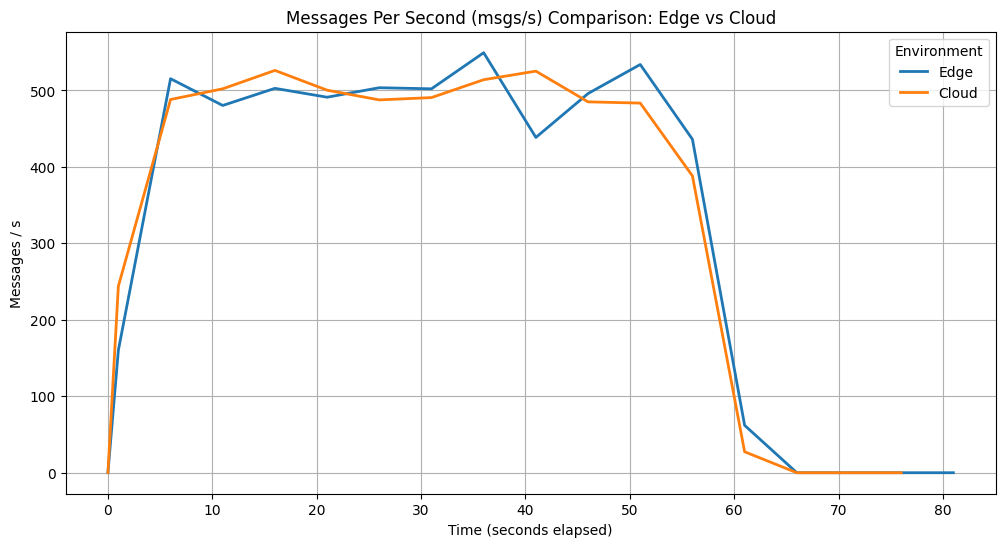

In [ ]:
# Process Data
df_edge = process_throughput(files_edge["messages"], start_time_edge, end_time_edge, "Edge")
df_cloud = process_throughput(files_cloud["messages"], start_time_cloud, end_time_cloud, "Cloud")

# Combine Data
combined_df = pd.concat([df_edge, df_cloud], ignore_index=True)

messages_per_second(combined_df, save_path="../../data/processed/final-01/smoke/messages_per_second.png") 

Processing Bytes for Edge...


/home/ark/streaming-pipeline/.venv/lib/python3.13/site-packages/fireducks/fallback.py:309: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret = attr(*args, **kwargs)
/home/ark/streaming-pipeline/.venv/lib/python3.13/site-packages/fireducks/fallback.py:309: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret = attr(*args, **kwargs)


Processing Bytes for Cloud...


/home/ark/streaming-pipeline/.venv/lib/python3.13/site-packages/fireducks/fallback.py:309: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret = attr(*args, **kwargs)
/home/ark/streaming-pipeline/.venv/lib/python3.13/site-packages/fireducks/fallback.py:309: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret = attr(*args, **kwargs)


Plotting Bytes Throughput...
Plot saved to ../../data/processed/final-01/smoke/throughput_bytes_comparison.png


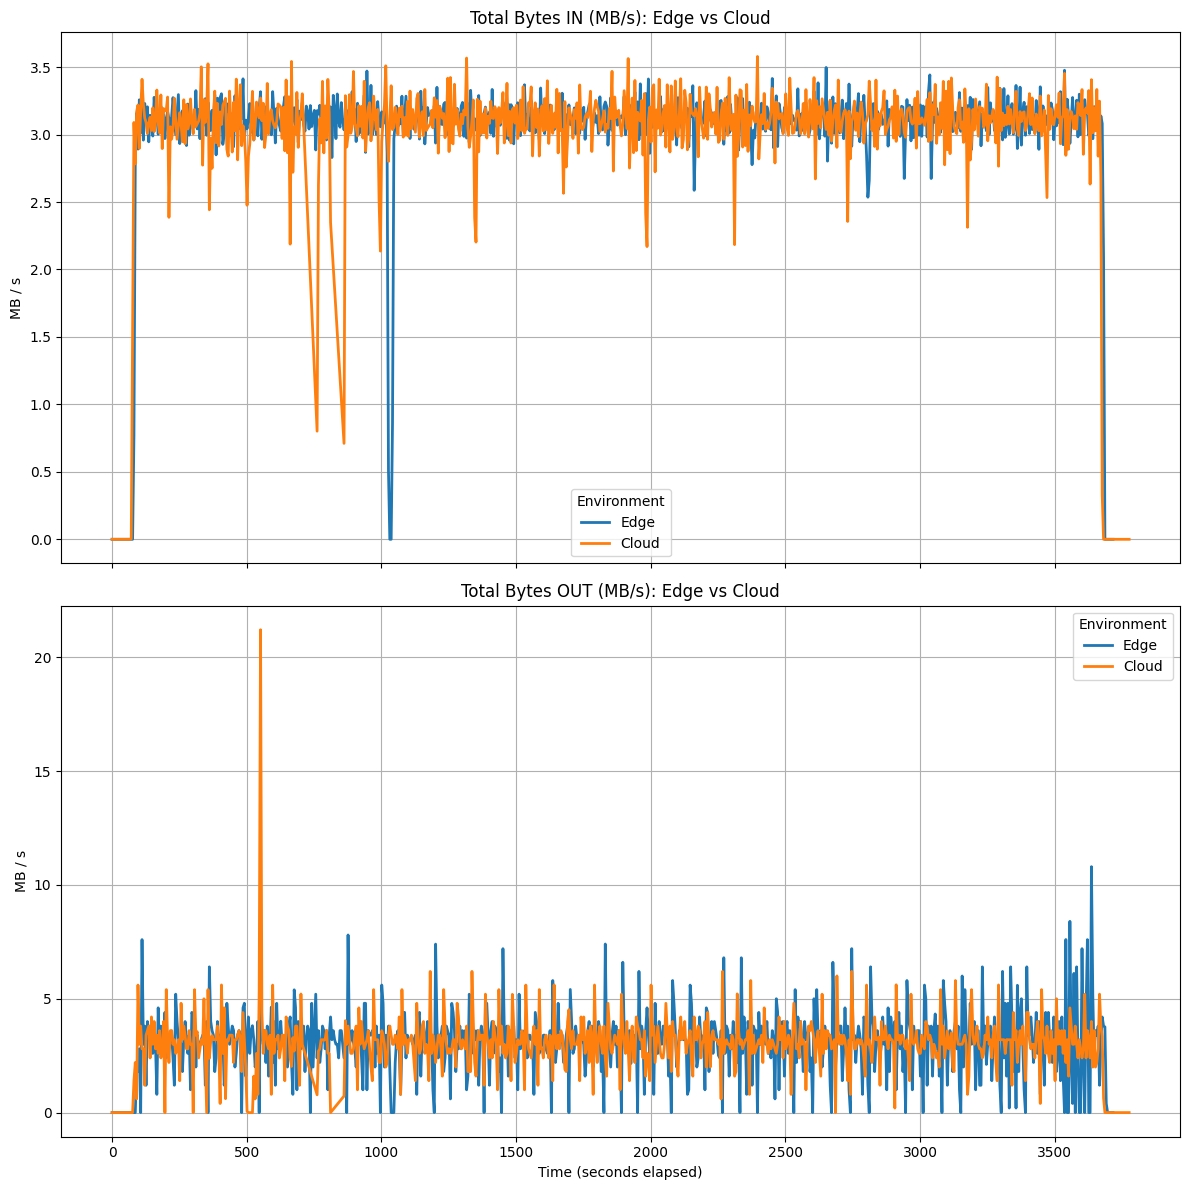

In [188]:
# 1. Process Edge
df_bytes_edge = process_bytes_throughput(
    files_edge, # dictionary containing 'bytes_in' and 'bytes_out' keys
    start_time_edge, 
    end_time_edge, 
    "Edge"
)

# 2. Process Cloud
df_bytes_cloud = process_bytes_throughput(
    files_cloud, 
    start_time_cloud, 
    end_time_cloud, 
    "Cloud"
)

# 3. Combine
df_bytes_combined = pd.concat([df_bytes_edge, df_bytes_cloud])

# 4. Plot
plot_bytes_throughput(df_bytes_combined, "../../data/processed/final-01/smoke/throughput_bytes_comparison.png")

## Latency Analysis

### Kafka

In [182]:
edge_file = "../../data/raw/final-01/k6_metrics/final-01-edge/smoke_edge.csv"
cloud_file = "../../data/raw/final-01/k6_metrics/final-01-cloud/smoke_cloud.csv"

df_edge, df_cloud = open_k6_files(edge_file, cloud_file)

In [183]:
metric_name="kafka_writer_write_seconds"
df_combined = prepare_data_for_chart(df_edge, df_cloud, metric_name)

             avg_metric   max_metric  min_metric  median_metric  p95_metric  \
Environment                                                                   
Edge          30.066285  1250.974681    0.988201       2.979402   73.866326   

             p99_metric  
Environment              
Edge         634.072059  


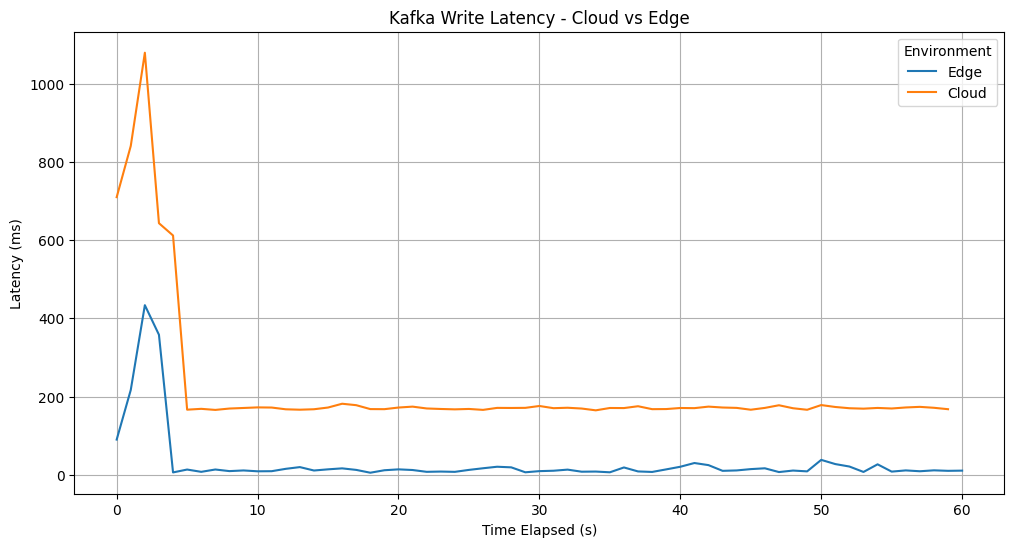

In [184]:
plot_kafka_writer_time(df_combined, save_path="../../data/processed/final-01/smoke/ack_time.png")

### Minio

In [203]:
data_edge = process_minio_env(minio_files_edge, start_time_edge, end_time_edge, "Edge")
data_cloud = process_minio_env(minio_files_cloud, start_time_cloud, end_time_cloud, "Cloud")

# Loop over the single item or just direct plot
key = 'latency'

df_e = data_edge.get(key, pd.DataFrame())
df_c = data_cloud.get(key, pd.DataFrame())

# Combine
df_combined = pd.concat([df_e, df_c], ignore_index=True)

Processing Edge...
Index(['timestamp', 'value'], dtype='object')
Processing Cloud...
Index(['timestamp', 'value'], dtype='object')


Plot saved to minio_comparison.png


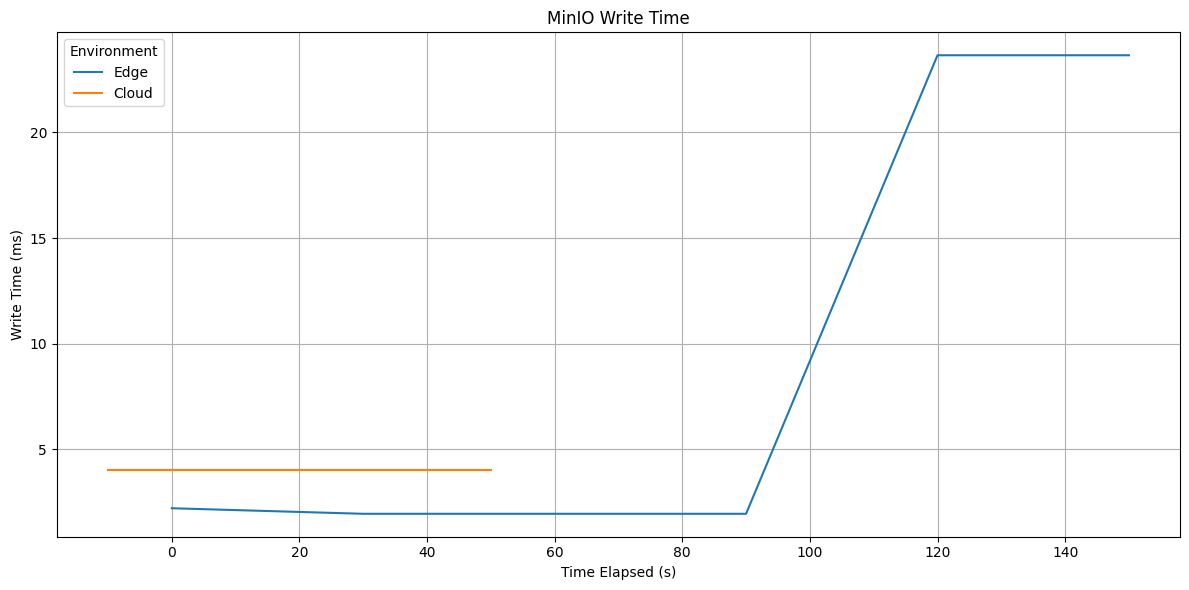

In [204]:
minio_analyze_metrics(df_combined, save_path="minio_comparison.png")

## Producer Resources

In [232]:
metric_name = 'vus'
smoke_k6_edge = get_aggregated_data_duckdb("../../data/raw/final-01/k6_metrics/final-01-edge/smoke_edge.csv", metric_name)
smoke_k6_cloud = get_aggregated_data_duckdb("../../data/raw/final-01/k6_metrics/final-01-cloud/smoke_cloud.csv", metric_name)

# Use specialized preparation for pre-aggregated data
df_combined = prepare_soak_data_for_chart(smoke_k6_edge, smoke_k6_cloud)

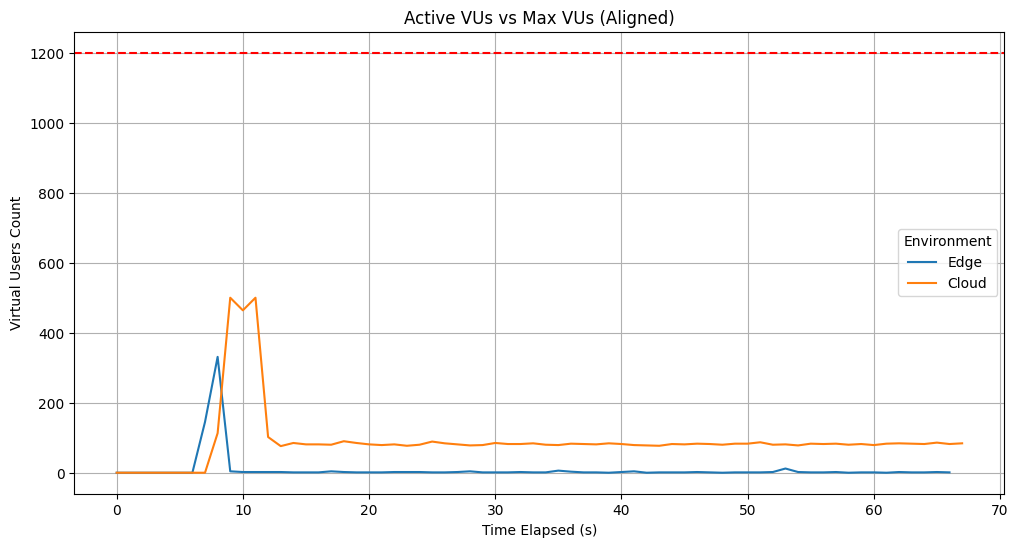

In [233]:
plot_vus(df_combined, save_path="../../data/processed/final-01/smoke/vus.png")

In [224]:
edge_file = "../../data/raw/final-01/k6_metrics/final-01-edge/resources_smoke_edge.csv"
cloud_file = "../../data/raw/final-01/k6_metrics/final-01-cloud/resources_smoke_cloud.csv"

df_resources = open_resources_files(edge_file, cloud_file)

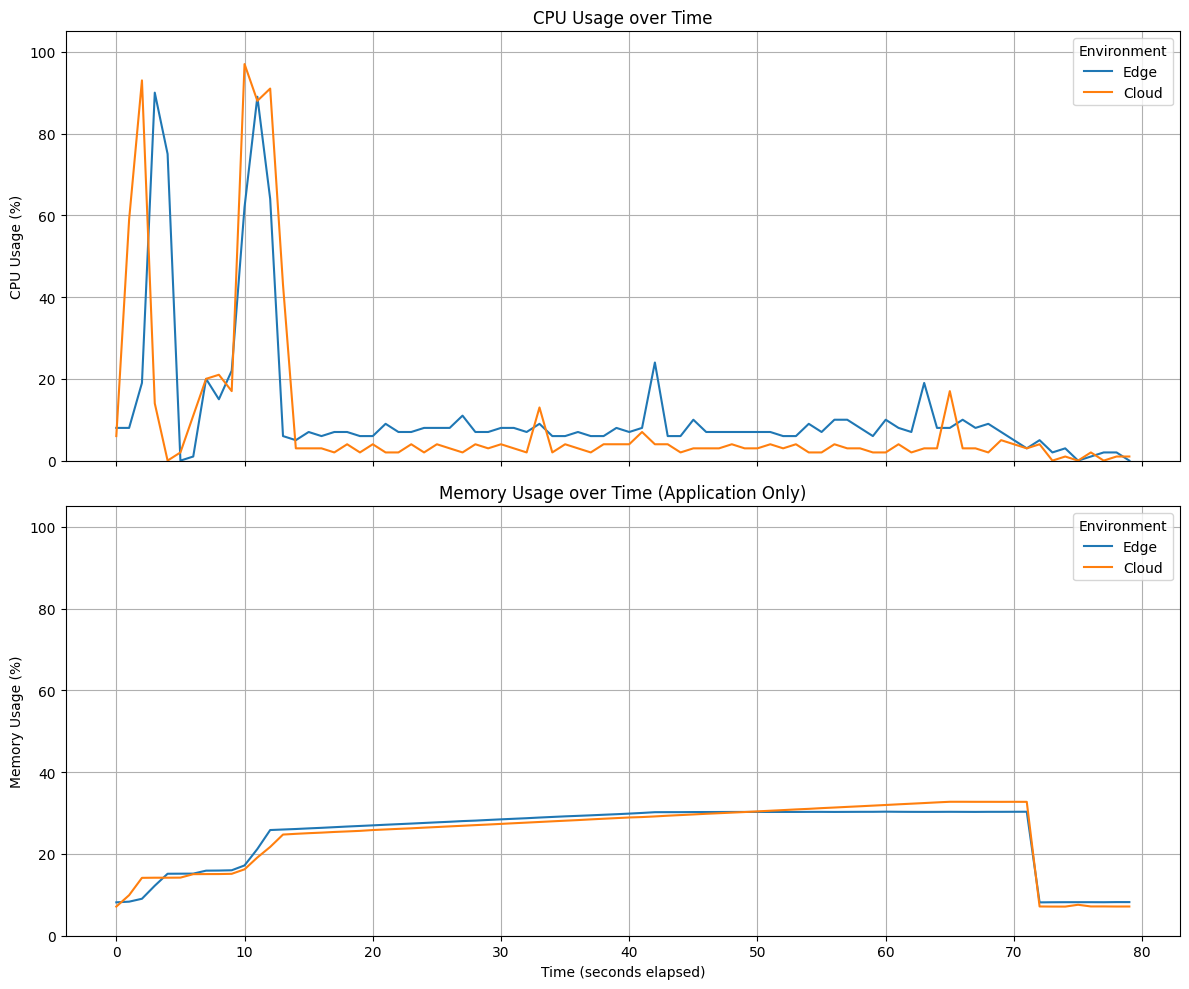

In [225]:
plot_resources(df_resources, save_path="../../data/processed/final-01/smoke/resources.png")

## Cluster Resources

# Stress Test

```go
stress: {
        executor: 'ramping-arrival-rate',
        startRate: 1000,
        timeUnit: '1s',
        preAllocatedVUs: 400,
        maxVUs: 1200,
        stages: [
            { target: 8000, duration: '5m' },
            { target: 8000, duration: '5m' },
            { target: 0, duration: '5m' },
        ],
    }
```

## Experiment Times

In [129]:
start_time_edge = pd.to_datetime("2026-01-05 19:05:00")
end_time_edge = pd.to_datetime("2026-01-05 19:23:00")
start_time_cloud = pd.to_datetime("2026-01-07 13:29:10")
end_time_cloud = pd.to_datetime("2026-01-07 13:47:10")

## Messages Per Second

Processing Edge...


/home/ark/streaming-pipeline/.venv/lib/python3.13/site-packages/fireducks/fallback.py:309: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret = attr(*args, **kwargs)


Processing Cloud...


/home/ark/streaming-pipeline/.venv/lib/python3.13/site-packages/fireducks/fallback.py:309: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret = attr(*args, **kwargs)


Plotting...
Plot saved to ../../data/processed/final-01/stress/messages_per_second.png


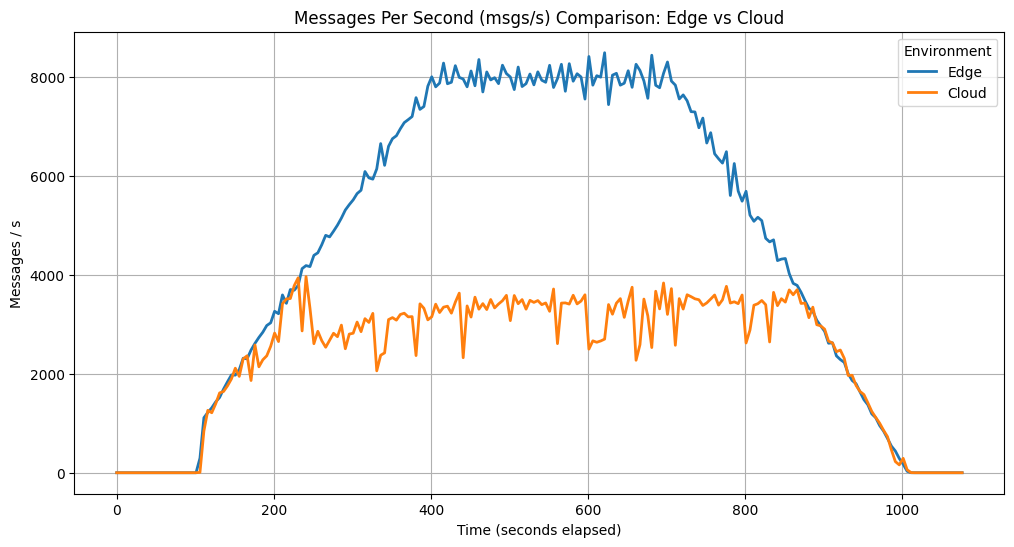

In [ ]:
file_edge = "../../data/raw/final-01/rerun/final-01_edge/kafka_server_brokertopicmetrics_messagesin_total.parquet"
file_cloud = "../../data/raw/final-01/rerun/final-01_cloud/kafka_server_brokertopicmetrics_messagesin_total.parquet"

# Process Data
df_edge = process_throughput(file_edge, start_time_edge, end_time_edge, "Edge")
df_cloud = process_throughput(file_cloud, start_time_cloud, end_time_cloud, "Cloud")

# Combine Data
combined_df = pd.concat([df_edge, df_cloud], ignore_index=True)

messages_per_second(combined_df, save_path="../../data/processed/final-01/stress/messages_per_second.png") 

Processing Bytes for Edge...


/home/ark/streaming-pipeline/.venv/lib/python3.13/site-packages/fireducks/fallback.py:309: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret = attr(*args, **kwargs)
/home/ark/streaming-pipeline/.venv/lib/python3.13/site-packages/fireducks/fallback.py:309: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret = attr(*args, **kwargs)


Processing Bytes for Cloud...


/home/ark/streaming-pipeline/.venv/lib/python3.13/site-packages/fireducks/fallback.py:309: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret = attr(*args, **kwargs)
/home/ark/streaming-pipeline/.venv/lib/python3.13/site-packages/fireducks/fallback.py:309: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret = attr(*args, **kwargs)


Plotting Bytes Throughput...
Plot saved to ../../data/processed/final-01/smoke/throughput_bytes_comparison.png


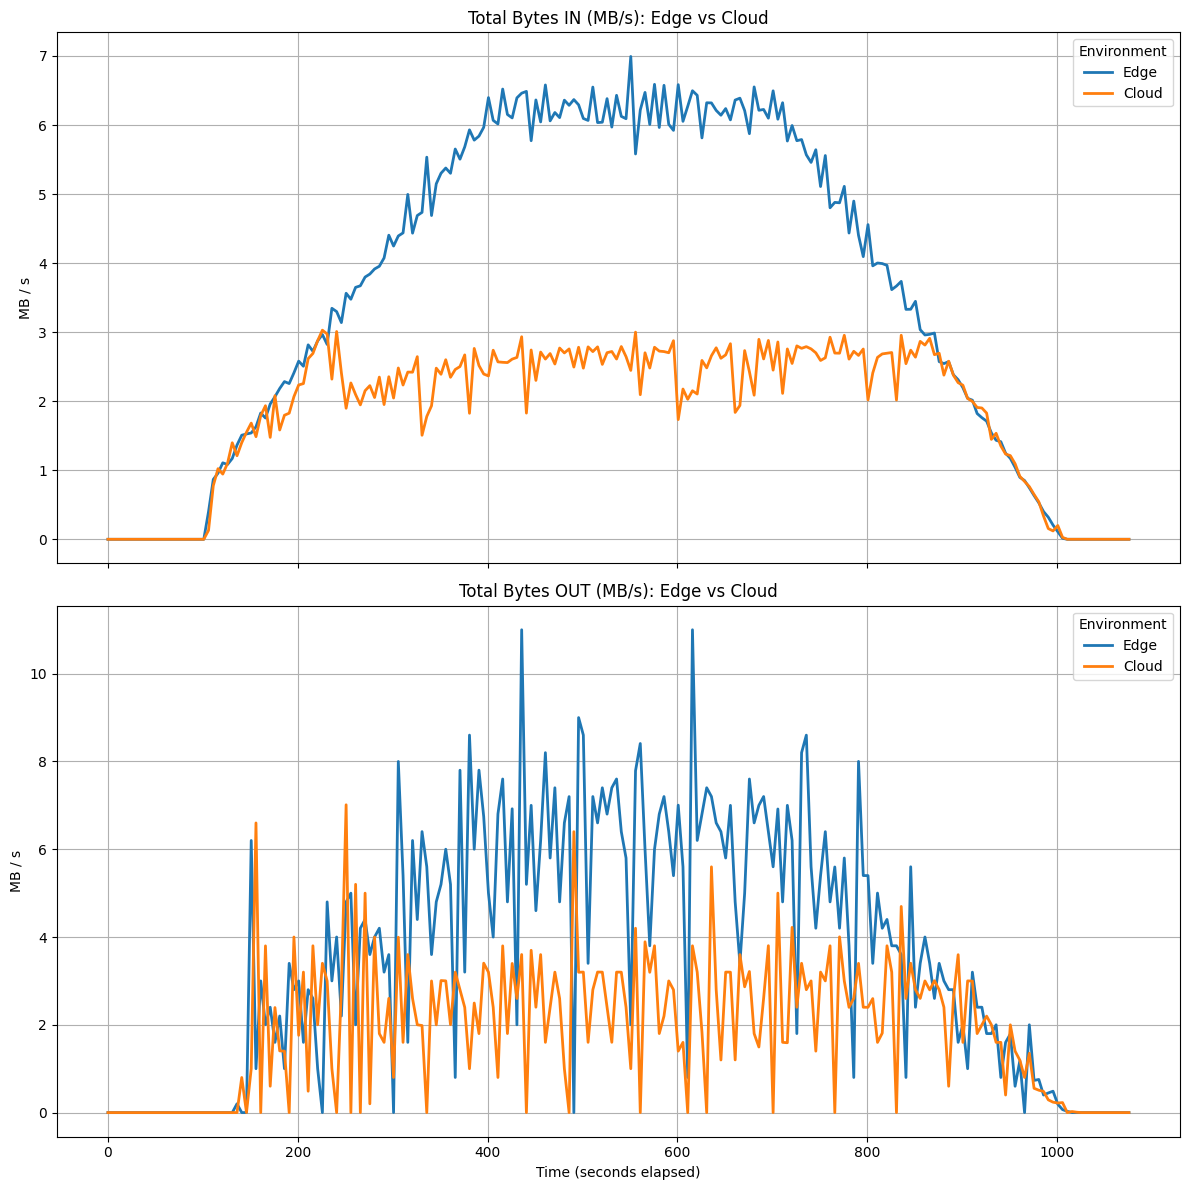

In [ ]:
data_folder_edge    = "../../data/raw/final-01/rerun/final-01_edge"
data_folder_cloud = "../../data/raw/final-01/rerun/final-01_cloud"

files_edge_rerun = {
    'bytes_in': f'{data_folder_edge}/kafka_server_brokertopicmetrics_bytesin_total.parquet',
    'bytes_out': f'{data_folder_edge}/kafka_server_brokertopicmetrics_bytesout_total.parquet',
}

files_cloud_rerun = {
    'bytes_in': f'{data_folder_cloud}/kafka_server_brokertopicmetrics_bytesin_total.parquet',
    'bytes_out': f'{data_folder_cloud}/kafka_server_brokertopicmetrics_bytesout_total.parquet',
}

# 1. Process Edge
df_bytes_edge = process_bytes_throughput(
    files_edge_rerun, # dictionary containing 'bytes_in' and 'bytes_out' keys
    start_time_edge, 
    end_time_edge, 
    "Edge"
)

# 2. Process Cloud
df_bytes_cloud = process_bytes_throughput(
    files_cloud_rerun, 
    start_time_cloud, 
    end_time_cloud, 
    "Cloud"
)

# 3. Combine
df_bytes_combined = pd.concat([df_bytes_edge, df_bytes_cloud])

# 4. Plot
plot_bytes_throughput(df_bytes_combined, "../../data/processed/final-01/stress/throughput_bytes_comparison.png")

## Latency Analysis

### Kafka

In [194]:
edge_file = "../../data/raw/final-01/rerun/stress_edge.csv"
cloud_file = "../../data/raw/final-01/rerun/stress_cloud.csv"

df_edge, df_cloud = open_k6_files(edge_file, cloud_file)

In [195]:
metric_name="kafka_writer_write_seconds"
df_combined = prepare_data_for_chart(df_edge, df_cloud, metric_name)

             avg_metric   max_metric  min_metric  median_metric  p95_metric  \
Environment                                                                   
Edge          16.838248  1042.271387    0.718802       2.975151   65.593317   

             p99_metric  
Environment              
Edge         105.134446  


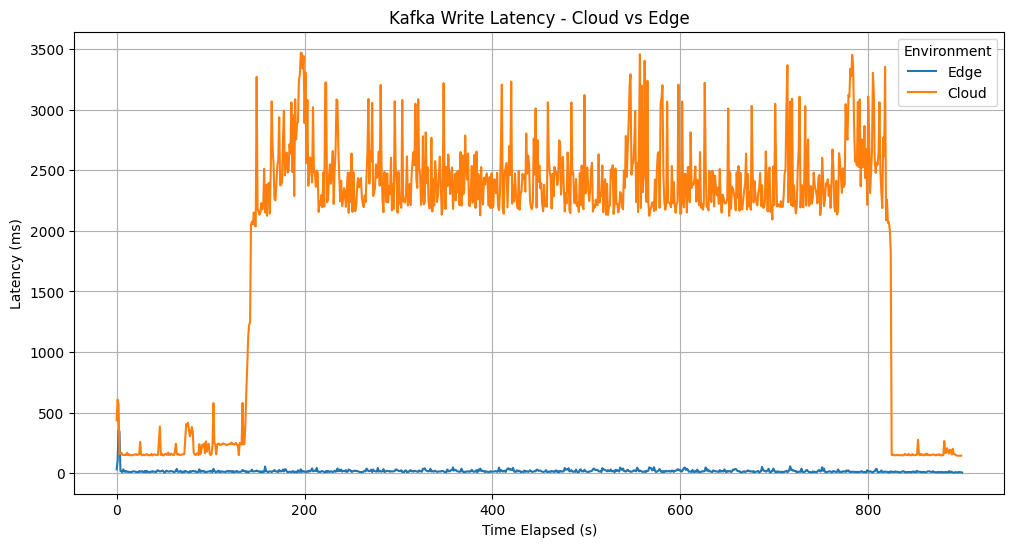

In [196]:
plot_kafka_writer_time(df_combined, save_path="../../data/processed/final-01/stress/ack_time.png")

### MinIO

In [199]:
data_folder_edge = "../../data/raw/final-01/rerun/final-01_edge"

stress_minio_files_edge = {
    'latency': f'{data_folder_edge}/minio_node_drive_latency_us.parquet',
}

data_folder_cloud = "../../data/raw/final-01/rerun/final-01_cloud"

stress_minio_files_cloud = {
    'latency': f'{data_folder_cloud}/minio_node_drive_latency_us.parquet',
}

In [200]:
data_edge = process_minio_env(stress_minio_files_edge, start_time_edge, end_time_edge, "Edge")
data_cloud = process_minio_env(stress_minio_files_cloud, start_time_cloud, end_time_cloud, "Cloud")

# Loop over the single item or just direct plot
key = 'latency'

df_e = data_edge.get(key, pd.DataFrame())
df_c = data_cloud.get(key, pd.DataFrame())

# Combine
df_combined = pd.concat([df_e, df_c], ignore_index=True)

Processing Edge...
Index(['timestamp', 'value'], dtype='object')
Processing Cloud...
Index(['timestamp', 'value'], dtype='object')


Plot saved to minio_comparison.png


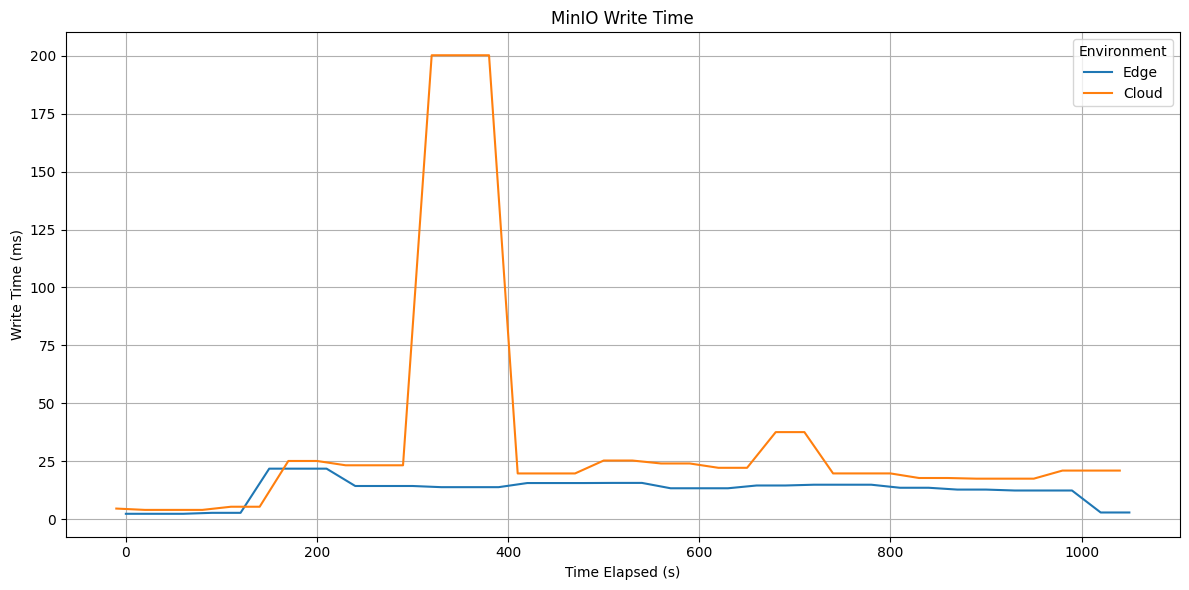

In [201]:
minio_analyze_metrics(df_combined, save_path="minio_comparison.png")

## Producer Resources

In [229]:
metric_name = 'vus'
stress_k6_edge = get_aggregated_data_duckdb("../../data/raw/final-01/rerun/stress_edge.csv", metric_name)
stress_k6_cloud = get_aggregated_data_duckdb("../../data/raw/final-01/rerun/stress_cloud.csv", metric_name)

# Use specialized preparation for pre-aggregated data
df_combined = prepare_soak_data_for_chart(stress_k6_edge, stress_k6_cloud)

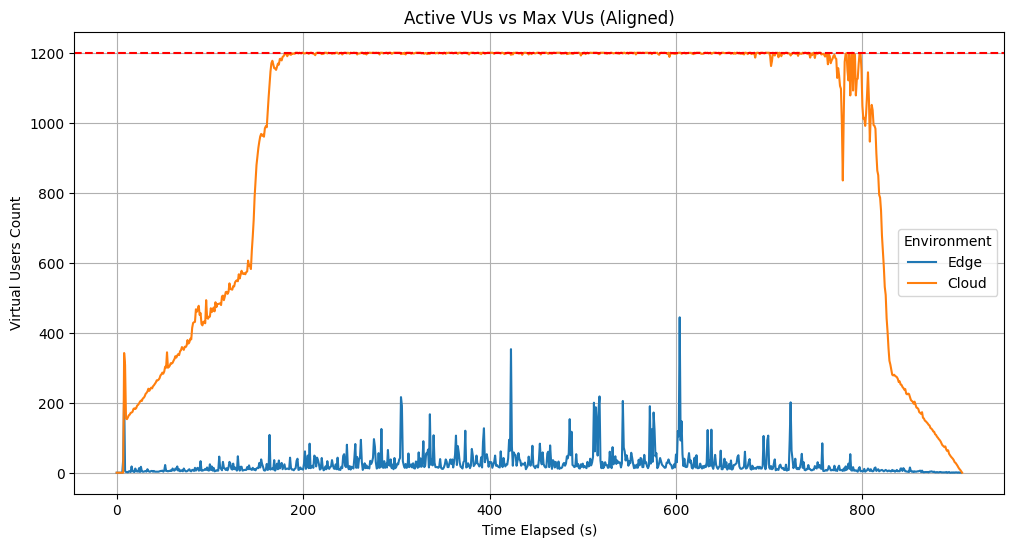

In [230]:
plot_vus(df_combined, save_path="../../data/processed/final-01/stress/vus.png")

In [222]:
edge_file = "../../data/raw/final-01/rerun/resources_stress_edge.csv"
cloud_file = "../../data/raw/final-01/rerun/resources_stress_cloud.csv"

df_resources = open_resources_files(edge_file, cloud_file)

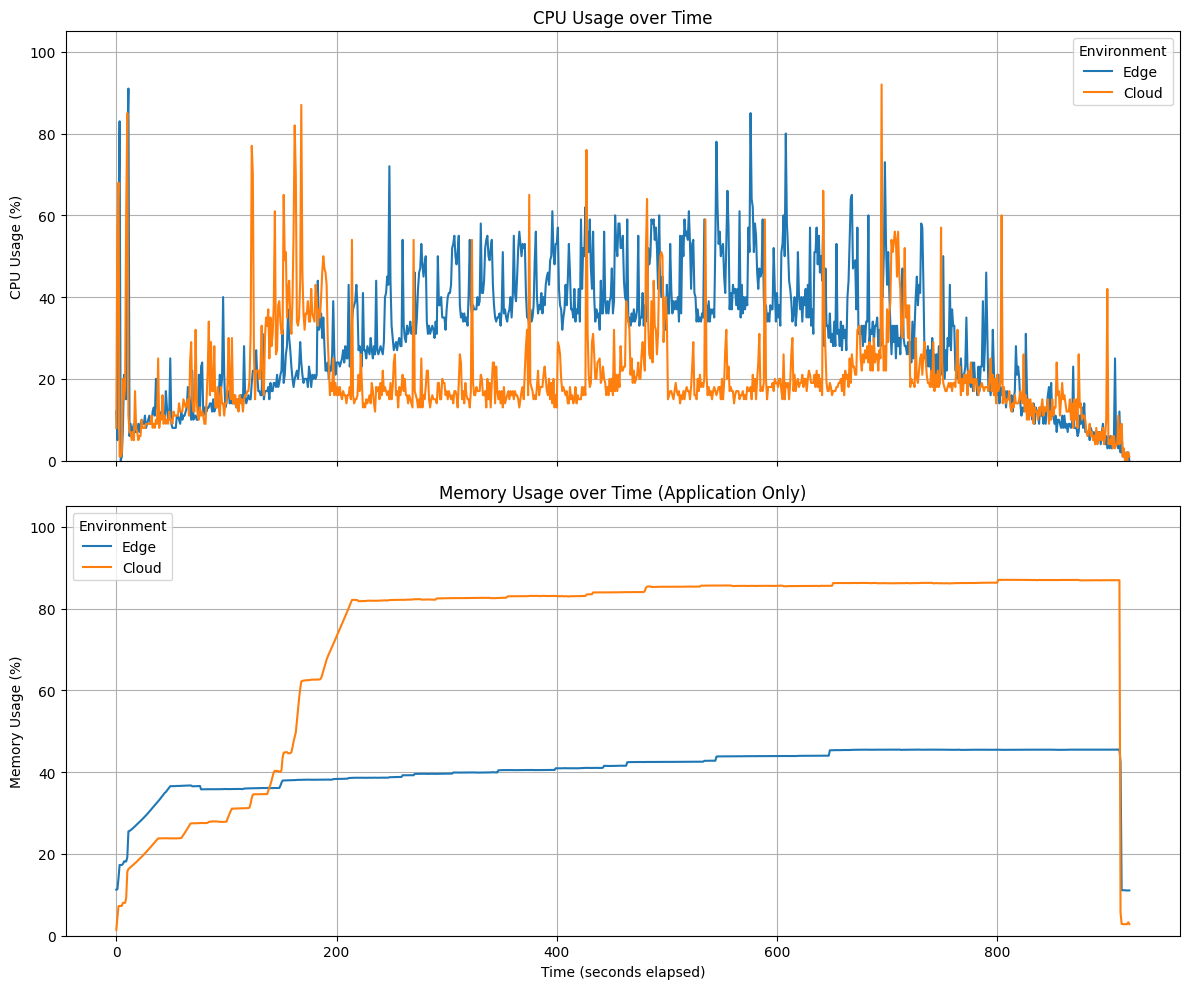

In [223]:
plot_resources(df_resources, save_path="../../data/processed/final-01/stress/resources.png")

## Cluster Resources

# Breakpoint Test

```go
breakpointcloud: {
    // Ramp up to find max sustainable rate
    executor: 'ramping-arrival-rate',
    startRate: 1000,
    timeUnit: '1s',
    preAllocatedVUs: 400,
    maxVUs: 1200,
    stages: [
        { target: 10000, duration: '15m' },
    ],
},
breakpointedge: {
        // Ramp up to find max sustainable rate
        executor: 'ramping-arrival-rate',
        startRate: 1000,
        timeUnit: '1s',
        preAllocatedVUs: 400,
        maxVUs: 1200,
        stages: [
            { target: 15000, duration: '15m' }, // Linear ramp to 15k to find breakpoint
        ],
},
```

## Messages Per Second

Processing Edge...


/home/ark/streaming-pipeline/.venv/lib/python3.13/site-packages/fireducks/fallback.py:309: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret = attr(*args, **kwargs)


Processing Cloud...


/home/ark/streaming-pipeline/.venv/lib/python3.13/site-packages/fireducks/fallback.py:309: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret = attr(*args, **kwargs)


Plotting...
Plot saved to ../../data/processed/final-01/breakpoint/messages_per_second_10k.png


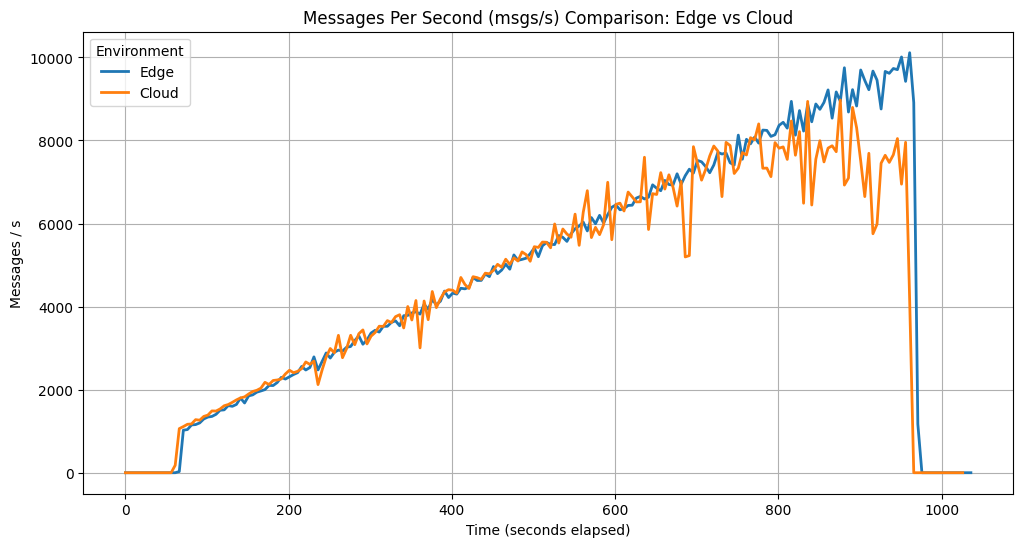

In [198]:
start_time_edge = pd.to_datetime("2026-01-05 19:22:20")
end_time_edge = pd.to_datetime("2026-01-05 19:40:00")
start_time_cloud = pd.to_datetime("2026-01-05 13:31:00")
end_time_cloud = pd.to_datetime("2026-01-05 13:48:10")


rerun_file_edge = "../../data/raw/final-01/rerun/final-01_edge/kafka_server_brokertopicmetrics_messagesin_total.parquet"
# Process Data
df_edge = process_throughput(rerun_file_edge, start_time_edge, end_time_edge, "Edge")
df_cloud = process_throughput(files_cloud["messages"], start_time_cloud, end_time_cloud, "Cloud")

# Combine Data
combined_df = pd.concat([df_edge, df_cloud], ignore_index=True)

messages_per_second(combined_df, save_path="../../data/processed/final-01/breakpoint/messages_per_second_10k.png") 

Processing Bytes for Edge...


/home/ark/streaming-pipeline/.venv/lib/python3.13/site-packages/fireducks/fallback.py:309: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret = attr(*args, **kwargs)
/home/ark/streaming-pipeline/.venv/lib/python3.13/site-packages/fireducks/fallback.py:309: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret = attr(*args, **kwargs)


Processing Bytes for Cloud...


/home/ark/streaming-pipeline/.venv/lib/python3.13/site-packages/fireducks/fallback.py:309: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret = attr(*args, **kwargs)
/home/ark/streaming-pipeline/.venv/lib/python3.13/site-packages/fireducks/fallback.py:309: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret = attr(*args, **kwargs)


Plotting Bytes Throughput...
Plot saved to ../../data/processed/final-01/breakpoint/throughput_bytes_comparison.png


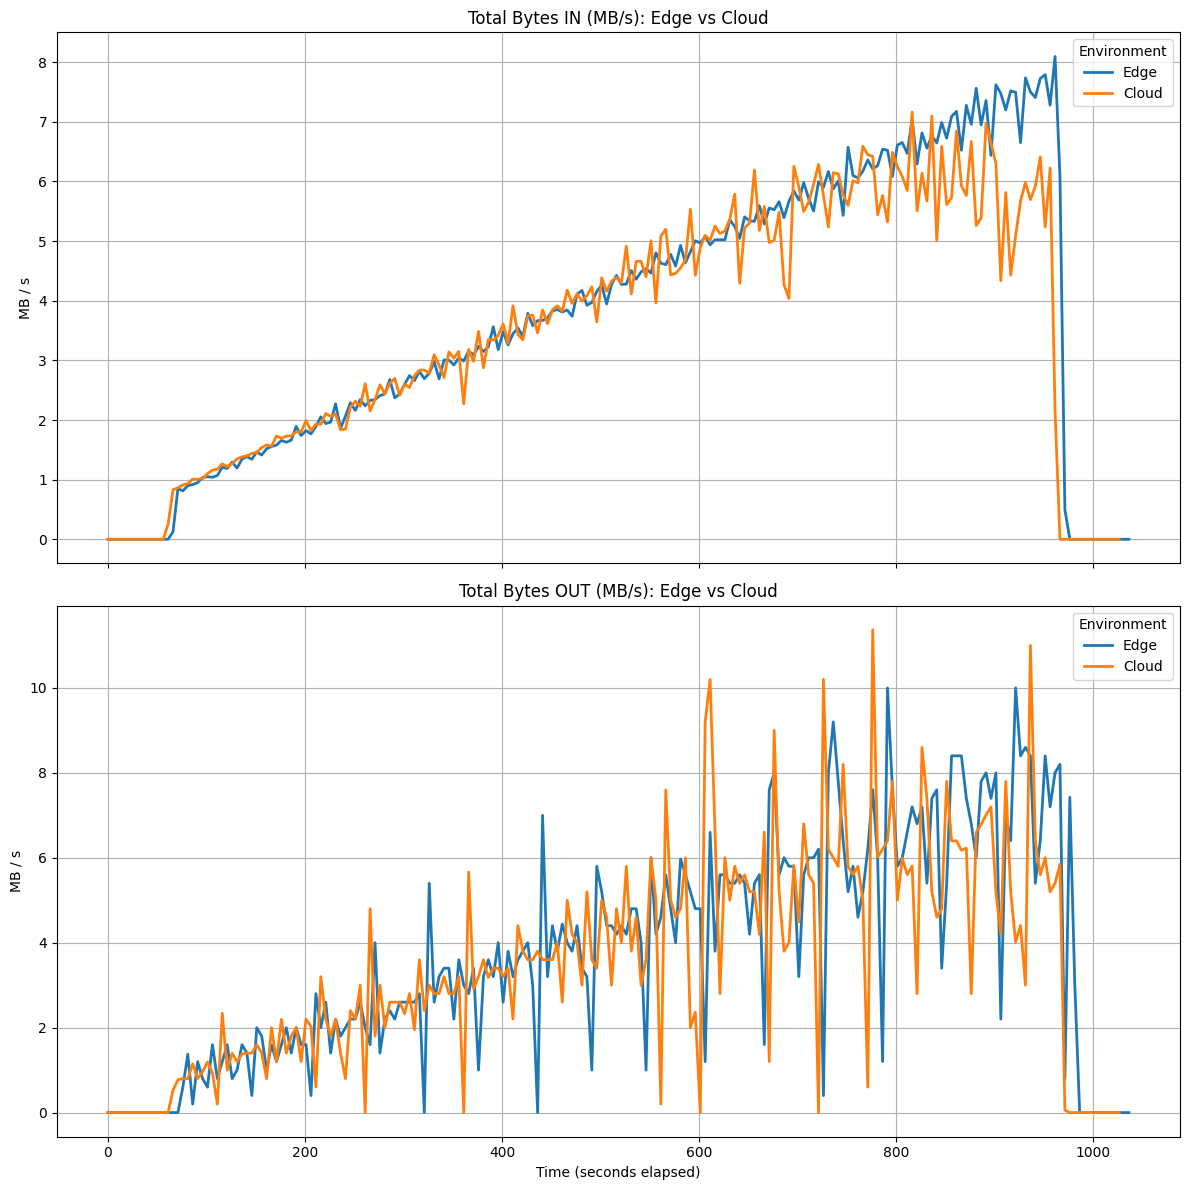

In [199]:
data_folder_edge    = "../../data/raw/final-01/rerun/final-01_edge"

files_edge_rerun = {
    'bytes_in': f'{data_folder_edge}/kafka_server_brokertopicmetrics_bytesin_total.parquet',
    'bytes_out': f'{data_folder_edge}/kafka_server_brokertopicmetrics_bytesout_total.parquet',
}

# 1. Process Edge
df_bytes_edge = process_bytes_throughput(
    files_edge_rerun, # dictionary containing 'bytes_in' and 'bytes_out' keys
    start_time_edge, 
    end_time_edge, 
    "Edge"
)

# 2. Process Cloud
df_bytes_cloud = process_bytes_throughput(
    files_cloud, 
    start_time_cloud, 
    end_time_cloud, 
    "Cloud"
)

# 3. Combine
df_bytes_combined = pd.concat([df_bytes_edge, df_bytes_cloud])

# 4. Plot
plot_bytes_throughput(df_bytes_combined, "../../data/processed/final-01/breakpoint/throughput_bytes_comparison.png")

Processing Edge...
Processing Cloud...


/home/ark/streaming-pipeline/.venv/lib/python3.13/site-packages/fireducks/fallback.py:309: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret = attr(*args, **kwargs)
/home/ark/streaming-pipeline/.venv/lib/python3.13/site-packages/fireducks/fallback.py:309: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret = attr(*args, **kwargs)


Plotting...
Plot saved to ../../data/processed/final-01/breakpoint/messages_per_second_15k.png


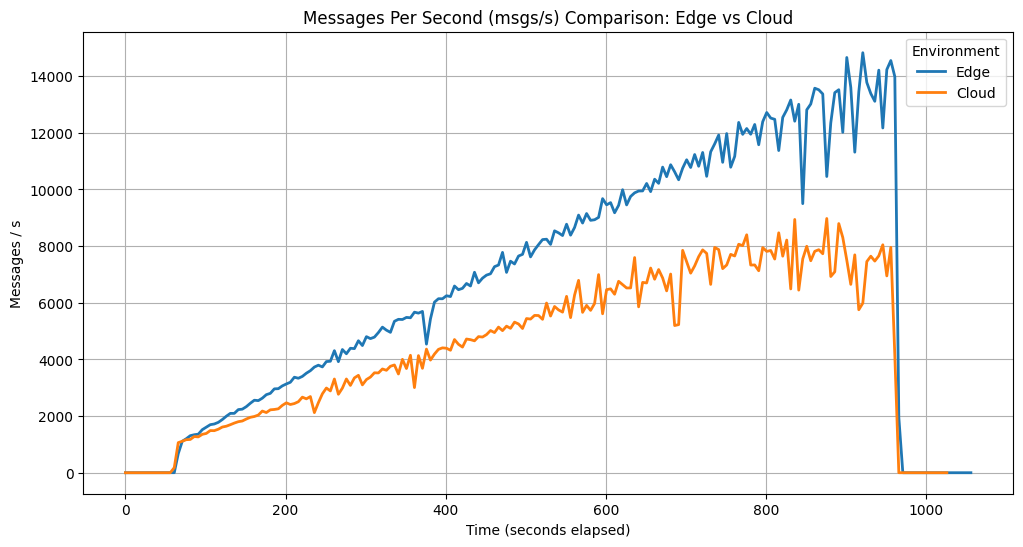

In [200]:
start_time_edge = pd.to_datetime("2026-01-05 16:07:20")
end_time_edge = pd.to_datetime("2026-01-05 16:25:00")
start_time_cloud = pd.to_datetime("2026-01-05 13:31:00")
end_time_cloud = pd.to_datetime("2026-01-05 13:48:10")

# Process Data
df_edge = process_throughput(files_edge["messages"], start_time_edge, end_time_edge, "Edge")
df_cloud = process_throughput(files_cloud["messages"], start_time_cloud, end_time_cloud, "Cloud")

# Combine Data
combined_df = pd.concat([df_edge, df_cloud], ignore_index=True)

messages_per_second(combined_df, save_path="../../data/processed/final-01/breakpoint/messages_per_second_15k.png") 

Processing Bytes for Edge...


/home/ark/streaming-pipeline/.venv/lib/python3.13/site-packages/fireducks/fallback.py:309: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret = attr(*args, **kwargs)
/home/ark/streaming-pipeline/.venv/lib/python3.13/site-packages/fireducks/fallback.py:309: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret = attr(*args, **kwargs)


Processing Bytes for Cloud...


/home/ark/streaming-pipeline/.venv/lib/python3.13/site-packages/fireducks/fallback.py:309: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret = attr(*args, **kwargs)
/home/ark/streaming-pipeline/.venv/lib/python3.13/site-packages/fireducks/fallback.py:309: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret = attr(*args, **kwargs)


Plotting Bytes Throughput...
Plot saved to ../../data/processed/final-01/breakpoint/throughput_bytes_comparison.png


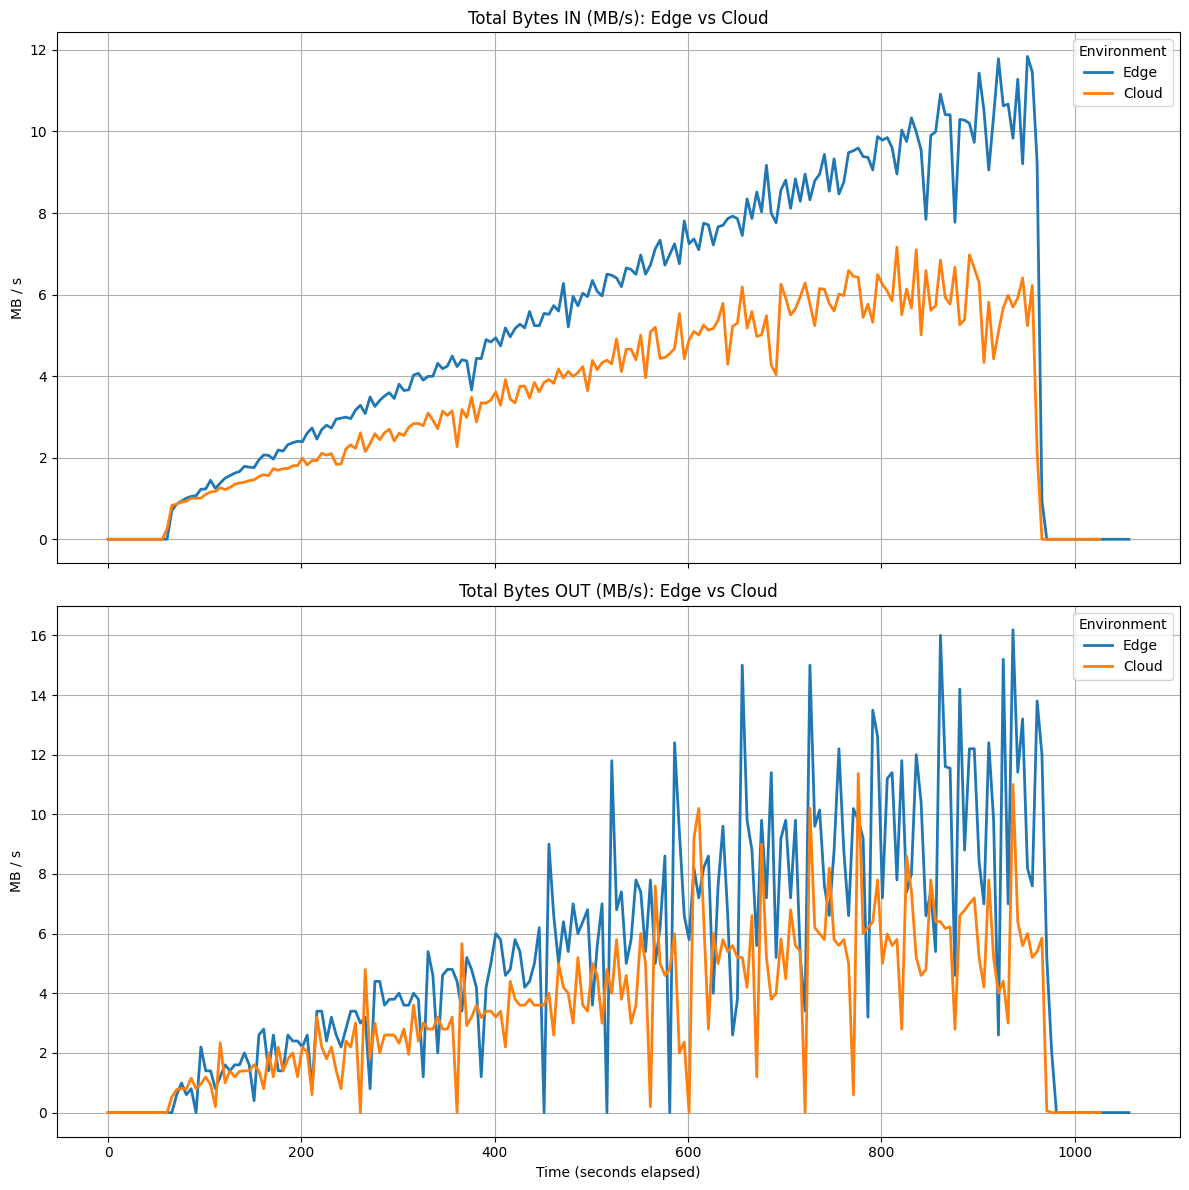

In [201]:
# 1. Process Edge
df_bytes_edge = process_bytes_throughput(
    files_edge, # dictionary containing 'bytes_in' and 'bytes_out' keys
    start_time_edge, 
    end_time_edge, 
    "Edge"
)

# 2. Process Cloud
df_bytes_cloud = process_bytes_throughput(
    files_cloud, 
    start_time_cloud, 
    end_time_cloud, 
    "Cloud"
)

# 3. Combine
df_bytes_combined = pd.concat([df_bytes_edge, df_bytes_cloud])

# 4. Plot
plot_bytes_throughput(df_bytes_combined, "../../data/processed/final-01/breakpoint/throughput_bytes_comparison.png")

## Latency Analysis

### Kafka

In [ ]:
edge_file = "../../data/raw/final-01/rerun/breakpoint_edge.csv"
cloud_file = "../../data/raw/final-01/k6_metrics/final-01-cloud/breakpoint_cloud.csv"

df_edge, df_cloud = open_k6_files(edge_file, cloud_file)

In [ ]:
metric_name="kafka_writer_write_seconds"
df_combined = prepare_data_for_chart(df_edge, df_cloud, metric_name)

             avg_metric   max_metric  min_metric  median_metric  p95_metric  \
Environment                                                                   
Edge           16.74915  1048.290967    0.743806       2.891591   61.760763   

             p99_metric  
Environment              
Edge         100.799725  


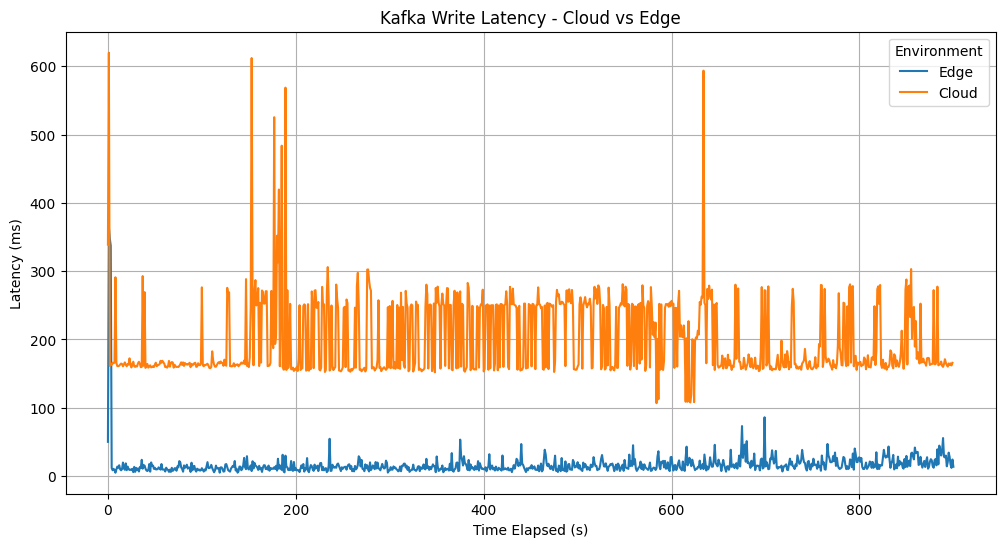

In [ ]:
plot_kafka_writer_time(df_combined, save_path="../../data/processed/final-01/breakpoint/ack_time.png")

## Producer Resources

In [227]:
metric_name = 'vus'
breakpoint_k6_edge = get_aggregated_data_duckdb("../../data/raw/final-01/rerun/breakpoint_edge.csv", metric_name)
breakpoint_k6_cloud = get_aggregated_data_duckdb("../../data/raw/final-01/k6_metrics/final-01-cloud/breakpoint_cloud.csv", metric_name)

# Use specialized preparation for pre-aggregated data
df_combined = prepare_soak_data_for_chart(breakpoint_k6_edge, breakpoint_k6_cloud)

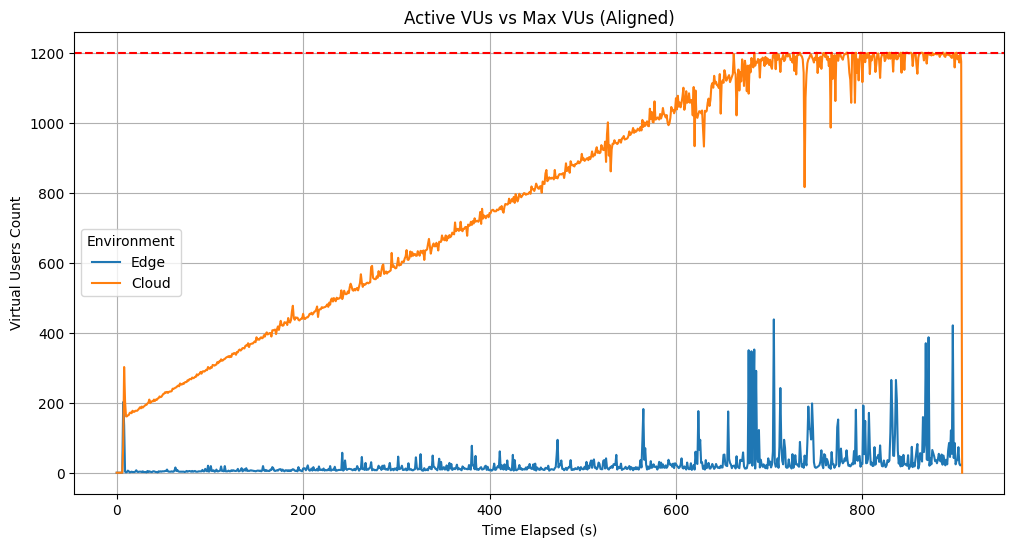

In [228]:
plot_vus(df_combined, save_path="../../data/processed/final-01/breakpoint/vus.png")

In [219]:
edge_file = "../../data/raw/final-01/rerun/resources_breakpoint_edge.csv"
cloud_file = "../../data/raw/final-01/k6_metrics/final-01-cloud/resources_breakpoint_cloud.csv"

df_resources = open_resources_files(edge_file, cloud_file)

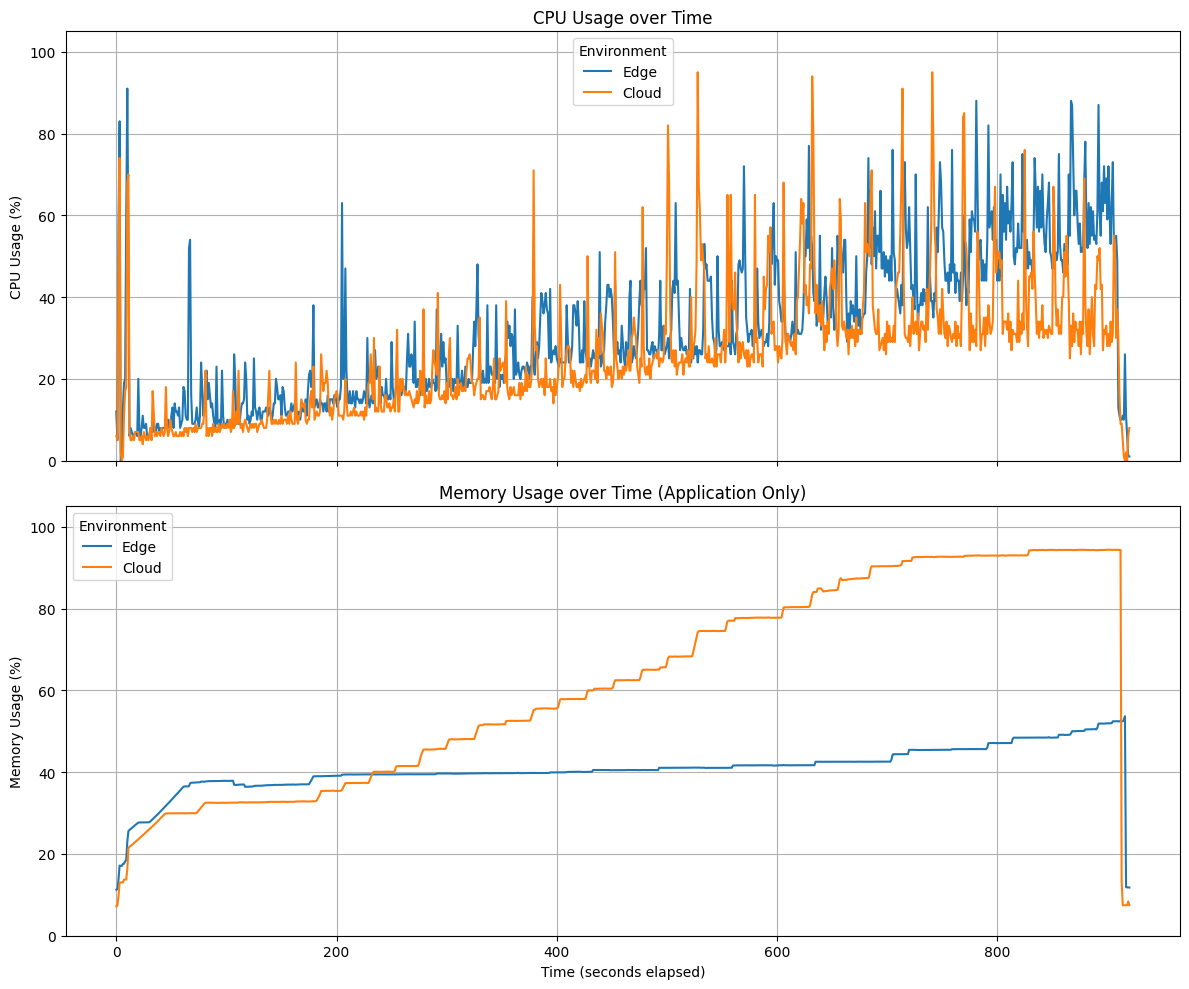

In [221]:
plot_resources(df_resources, save_path="../../data/processed/final-01/breakpoint/resources.png")

## Cluster Resources

# Soak Test

```go
soak: {
        // Long duration at nominal load
        executor: 'constant-arrival-rate',
        rate: 4000,
        timeUnit: '1s',
        duration: '1h',
        preAllocatedVUs: 400,
        maxVUs: 1200,
    }
```

## Messages Per Second

In [234]:
start_time_edge = pd.to_datetime("2026-01-05 16:25:00")
end_time_edge = pd.to_datetime("2026-01-05 17:28:00")
start_time_cloud = pd.to_datetime("2026-01-05 13:48:00")
end_time_cloud = pd.to_datetime("2026-01-05 14:51:00")

Processing Edge...


/home/ark/streaming-pipeline/.venv/lib/python3.13/site-packages/fireducks/fallback.py:309: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret = attr(*args, **kwargs)


Processing Cloud...


/home/ark/streaming-pipeline/.venv/lib/python3.13/site-packages/fireducks/fallback.py:309: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret = attr(*args, **kwargs)


Plotting...
Plot saved to ../../data/processed/final-01/soak/messages_per_second.png


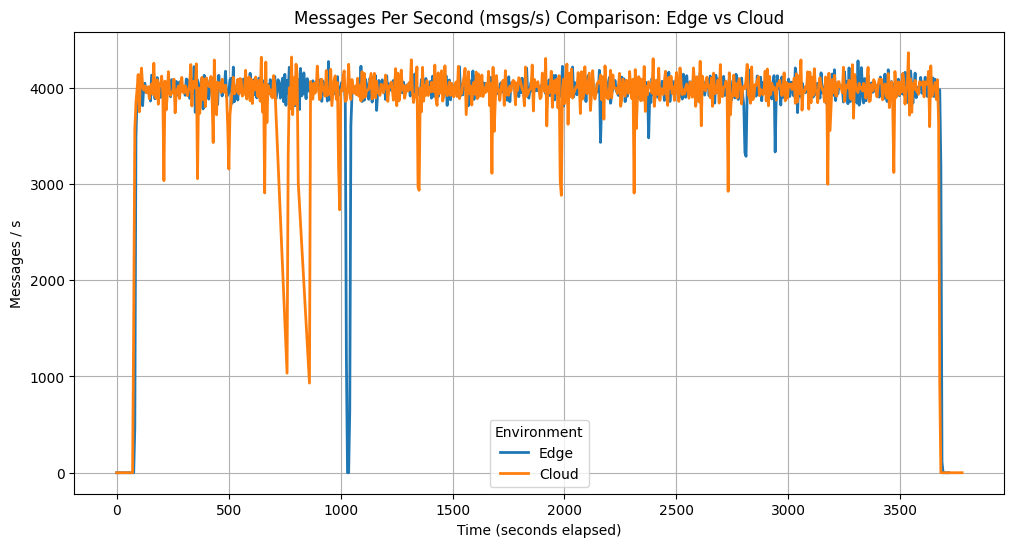

In [ ]:
# Process Data
df_edge = process_throughput(files_edge["messages"], start_time_edge, end_time_edge, "Edge")
df_cloud = process_throughput(files_cloud["messages"], start_time_cloud, end_time_cloud, "Cloud")

# Combine Data
combined_df = pd.concat([df_edge, df_cloud], ignore_index=True)

messages_per_second(combined_df, save_path="../../data/processed/final-01/soak/messages_per_second.png") 

Processing Bytes for Edge...


/home/ark/streaming-pipeline/.venv/lib/python3.13/site-packages/fireducks/fallback.py:309: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret = attr(*args, **kwargs)
/home/ark/streaming-pipeline/.venv/lib/python3.13/site-packages/fireducks/fallback.py:309: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret = attr(*args, **kwargs)


Processing Bytes for Cloud...


/home/ark/streaming-pipeline/.venv/lib/python3.13/site-packages/fireducks/fallback.py:309: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret = attr(*args, **kwargs)
/home/ark/streaming-pipeline/.venv/lib/python3.13/site-packages/fireducks/fallback.py:309: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret = attr(*args, **kwargs)


Plotting Bytes Throughput...
Plot saved to ../../data/processed/final-01/soak/throughput_bytes_comparison.png


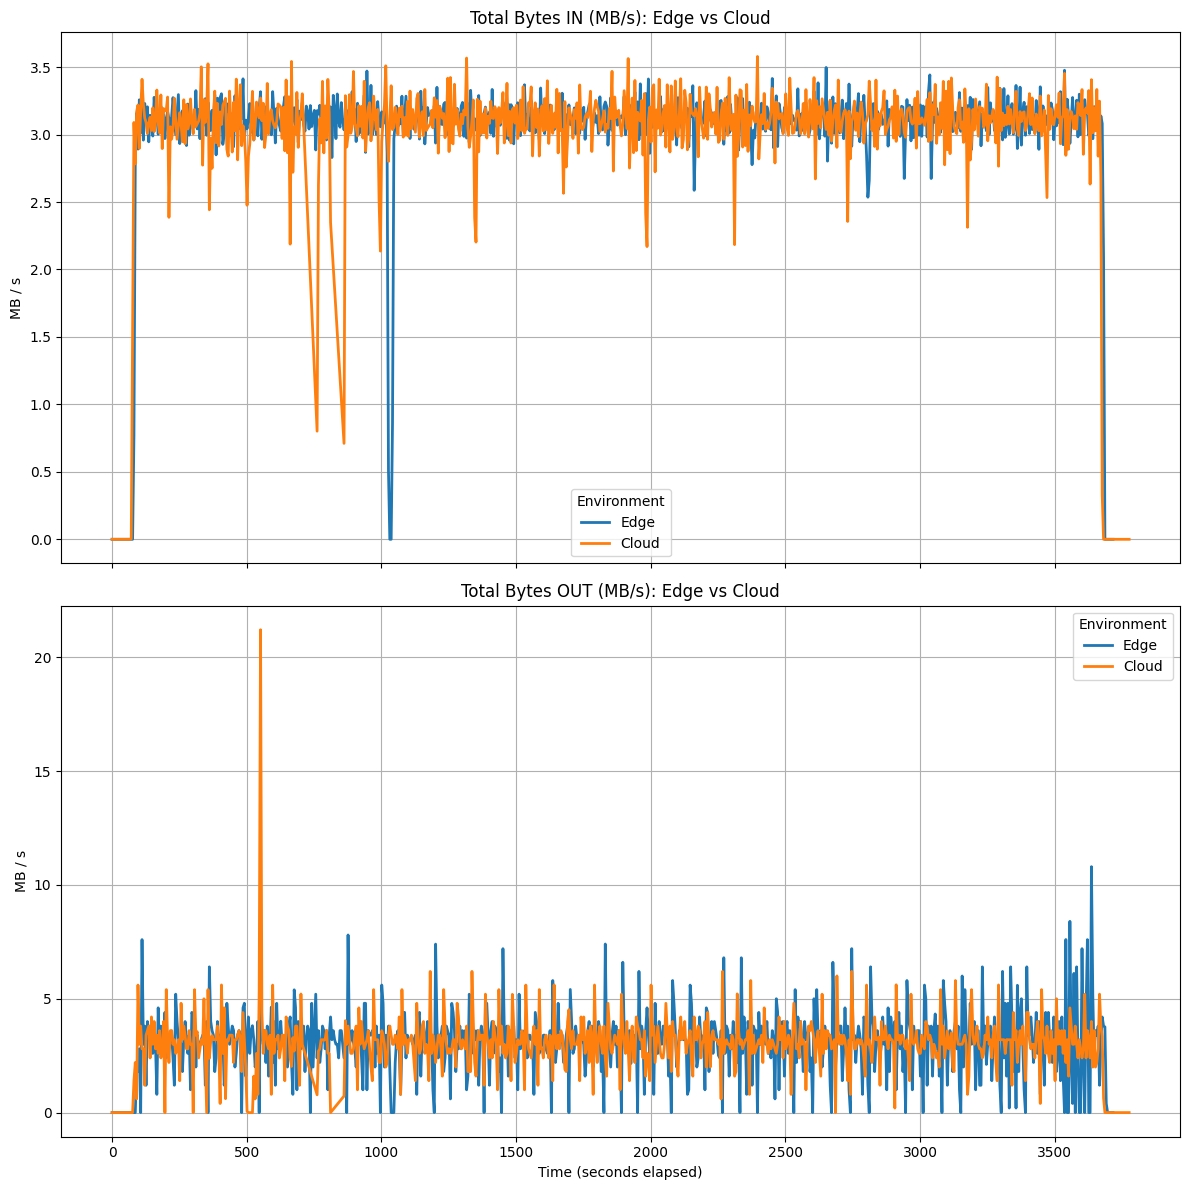

In [235]:
# 1. Process Edge
df_bytes_edge = process_bytes_throughput(
    files_edge, # dictionary containing 'bytes_in' and 'bytes_out' keys
    start_time_edge, 
    end_time_edge, 
    "Edge"
)

# 2. Process Cloud
df_bytes_cloud = process_bytes_throughput(
    files_cloud, 
    start_time_cloud, 
    end_time_cloud, 
    "Cloud"
)

# 3. Combine
df_bytes_combined = pd.concat([df_bytes_edge, df_bytes_cloud])

# 4. Plot
plot_bytes_throughput(df_bytes_combined, "../../data/processed/final-01/soak/throughput_bytes_comparison.png")

## Latency Analysis

### Kafka

In [208]:
metric_name = 'kafka_writer_write_seconds'

soak_k6_edge = get_aggregated_data_duckdb("../../data/raw/final-01/k6_metrics/final-01-edge/soak_edge.csv", metric_name)
soak_k6_cloud = get_aggregated_data_duckdb("../../data/raw/final-01/k6_metrics/final-01-cloud/soak_cloud.csv", metric_name)

In [209]:
# Use specialized preparation for pre-aggregated data
df_combined = prepare_soak_data_for_chart(soak_k6_edge, soak_k6_cloud)

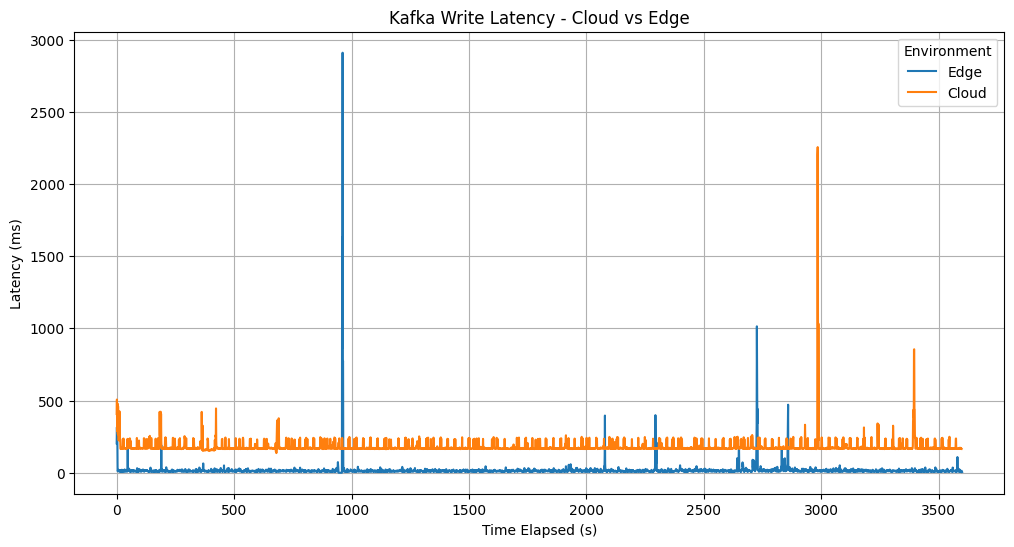

In [210]:
plot_kafka_writer_time(df_combined, save_path="../../data/processed/final-01/soak/ack_time.png")

## Producer Resources

In [213]:
metric_name = 'vus'
soak_k6_edge = get_aggregated_data_duckdb("../../data/raw/final-01/k6_metrics/final-01-edge/soak_edge.csv", metric_name)
soak_k6_cloud = get_aggregated_data_duckdb("../../data/raw/final-01/k6_metrics/final-01-cloud/soak_cloud.csv", metric_name)

# Use specialized preparation for pre-aggregated data
df_combined = prepare_soak_data_for_chart(soak_k6_edge, soak_k6_cloud)

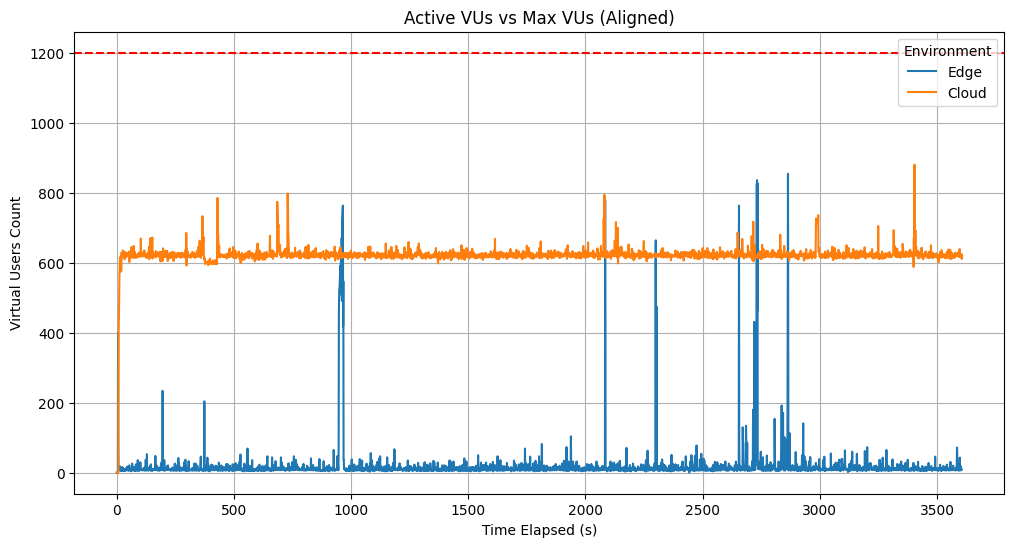

In [214]:
plot_vus(df_combined, save_path="../../data/processed/final-01/soak/vus.png")

In [217]:
edge_file = "../../data/raw/final-01/k6_metrics/final-01-edge/resources_soak_edge.csv"
cloud_file = "../../data/raw/final-01/k6_metrics/final-01-cloud/resources_soak_cloud.csv"

df_resources = open_resources_files(edge_file, cloud_file)

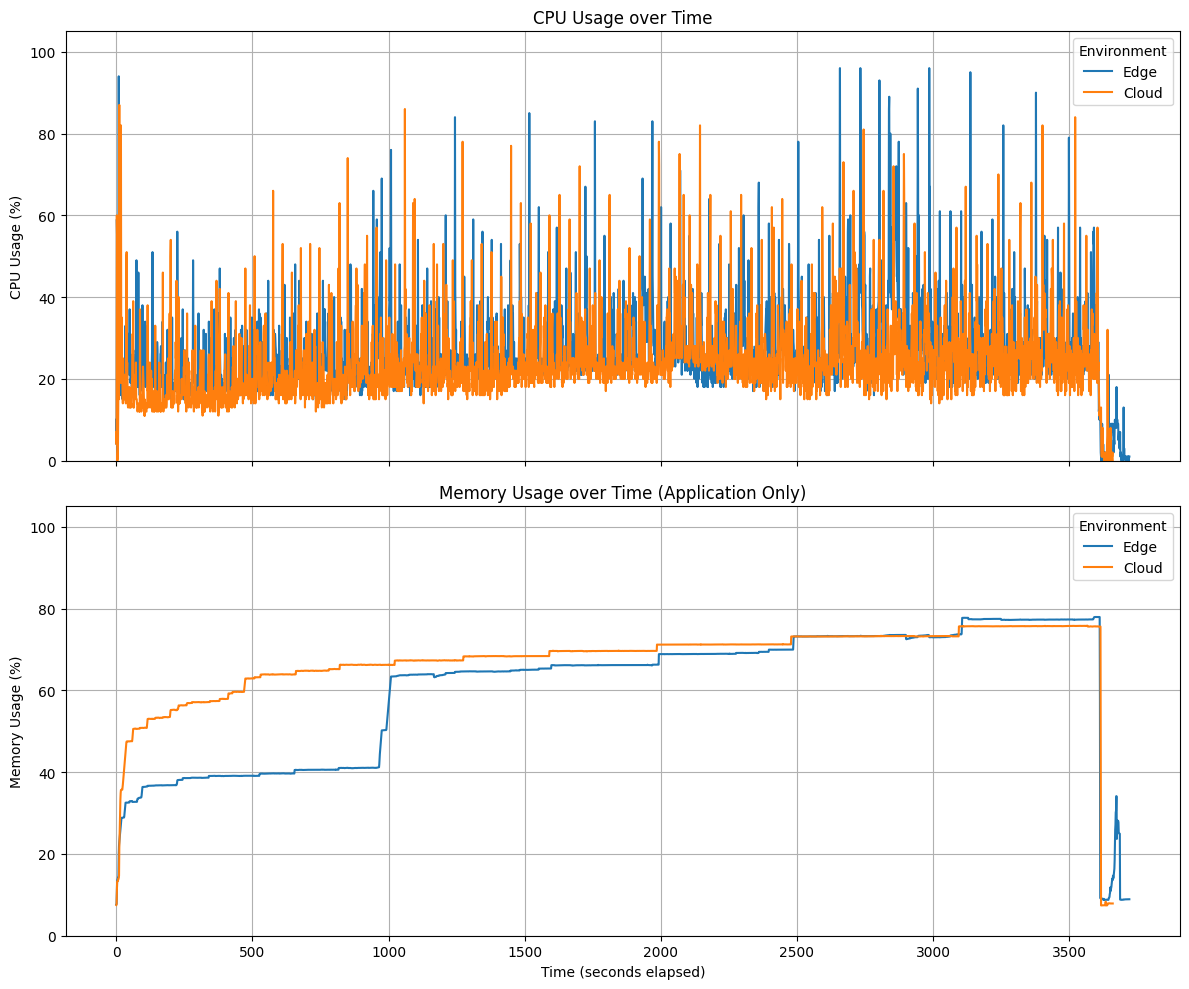

In [218]:
plot_resources(df_resources, save_path="../../data/processed/final-01/soak/resources.png")

## Cluster Resources